# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from matplotlib import rcParams

from sklearn.ensemble import  RandomForestRegressor, IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [5]:
from keras.models import Sequential
from keras.layers import Dense

# Some preprocessing

In [6]:
data = pd.read_csv("./collected_data/prepared_data/prestep_data.csv")
data.head()

vertices  redexes  redex_depths  redex_indexes  heights  widths  \
0        53        3             4             12       15      21   
1        50        2             5             27       15      20   
2        27        1             1              1        8      10   
3        54        6             7             10       13      17   
4        51        6            11             16       14      16   

   steps_time strategy_name  
0      131224            LI  
1      187277            LI  
2       32085            LI  
3      179030            LI  
4      179197            LI

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3931 entries, 0 to 3930
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   vertices       3931 non-null   int64 
 1   redexes        3931 non-null   int64 
 2   redex_depths   3931 non-null   int64 
 3   redex_indexes  3931 non-null   int64 
 4   heights        3931 non-null   int64 
 5   widths         3931 non-null   int64 
 6   steps_time     3931 non-null   int64 
 7   strategy_name  3931 non-null   object
dtypes: int64(7), object(1)
memory usage: 245.8+ KB


In [8]:
pca = PCA(2, random_state=42)
data_pca = pca.fit_transform(data[["vertices", "redexes", "redex_depths", "heights", "widths"]])

C:\Users\voldo\AppData\Local\Temp\ipykernel_10804\2351182786.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], palette="deep")


<AxesSubplot: >

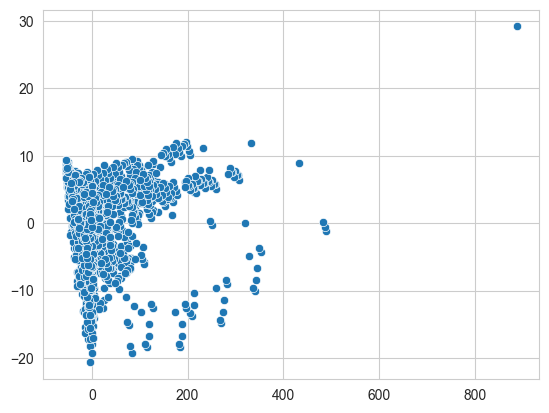

In [9]:
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], palette="deep")

<AxesSubplot: >

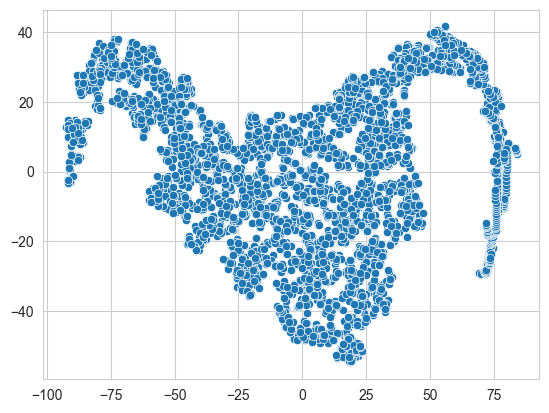

In [10]:
tsne = TSNE(random_state=3)
tsne_feature = tsne.fit_transform(data[["vertices", "redexes", "redex_depths", "heights", "widths"]])
sns.scatterplot(x=tsne_feature[:, 0], y=tsne_feature[:, 1])

## Check skewed features

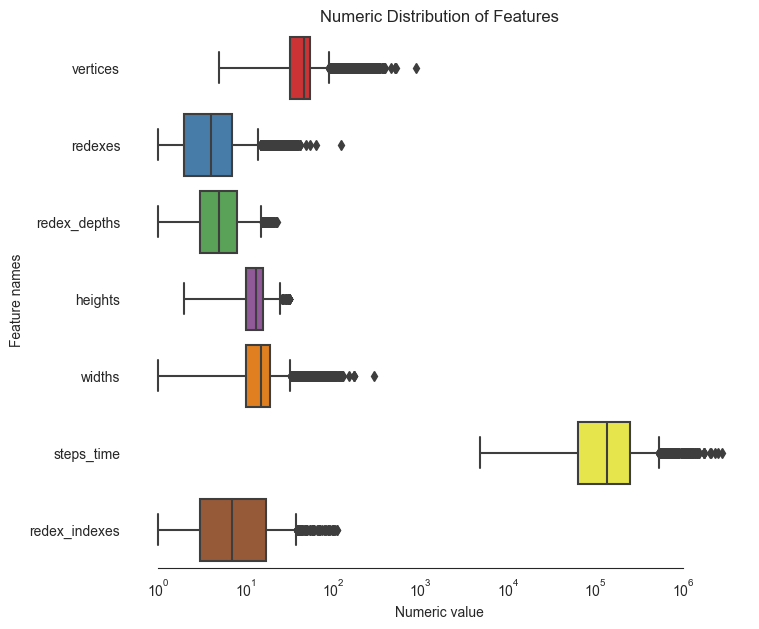

In [11]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=data[["vertices", "redexes", "redex_depths", "heights", "widths", "steps_time", "redex_indexes"]], orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric value")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [12]:
# Find skewed numerical features
skew_features = data[["vertices", "redexes", "redex_depths", "heights", "widths", "steps_time", "redex_indexes"]].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print(f"There are {high_skew.shape[0]} numerical features with skew > 0.5: ")
skewness = pd.DataFrame({"skew": skew_features})
skewness.head(10)

There are 6 numerical features with skew > 0.5: 


skew
vertices       4.235690
widths         4.148381
redexes        3.953192
steps_time     3.692667
redex_indexes  2.305134
redex_depths   1.034103
heights        0.428418

array([[<AxesSubplot: title={'center': 'vertices'}>,
        <AxesSubplot: title={'center': 'redexes'}>,
        <AxesSubplot: title={'center': 'redex_depths'}>],
       [<AxesSubplot: title={'center': 'redex_indexes'}>,
        <AxesSubplot: title={'center': 'heights'}>,
        <AxesSubplot: title={'center': 'widths'}>],
       [<AxesSubplot: title={'center': 'steps_time'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

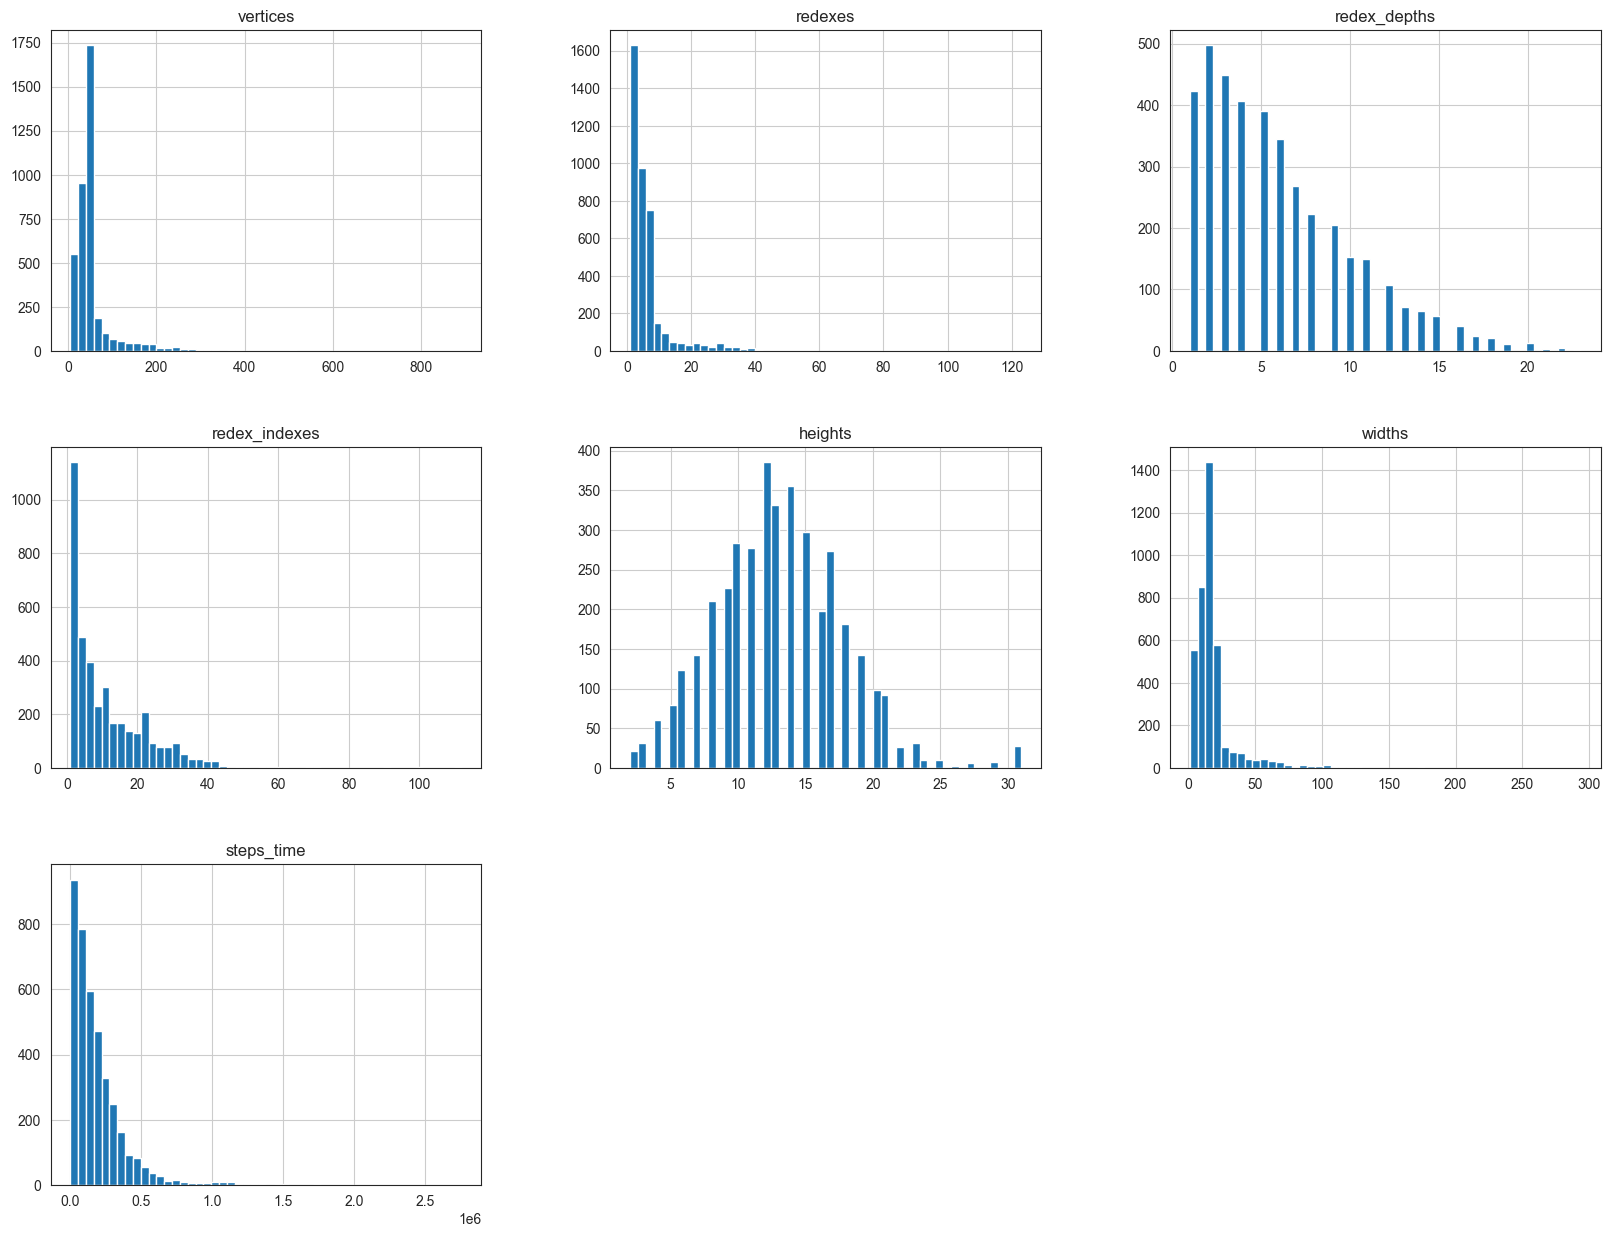

In [13]:
rcParams['figure.figsize'] = 20, 15
data.hist(bins=50)

array([[<AxesSubplot: title={'center': 'vertices'}>,
        <AxesSubplot: title={'center': 'redexes'}>],
       [<AxesSubplot: title={'center': 'redex_depths'}>,
        <AxesSubplot: title={'center': 'heights'}>],
       [<AxesSubplot: title={'center': 'widths'}>,
        <AxesSubplot: title={'center': 'steps_time'}>]], dtype=object)

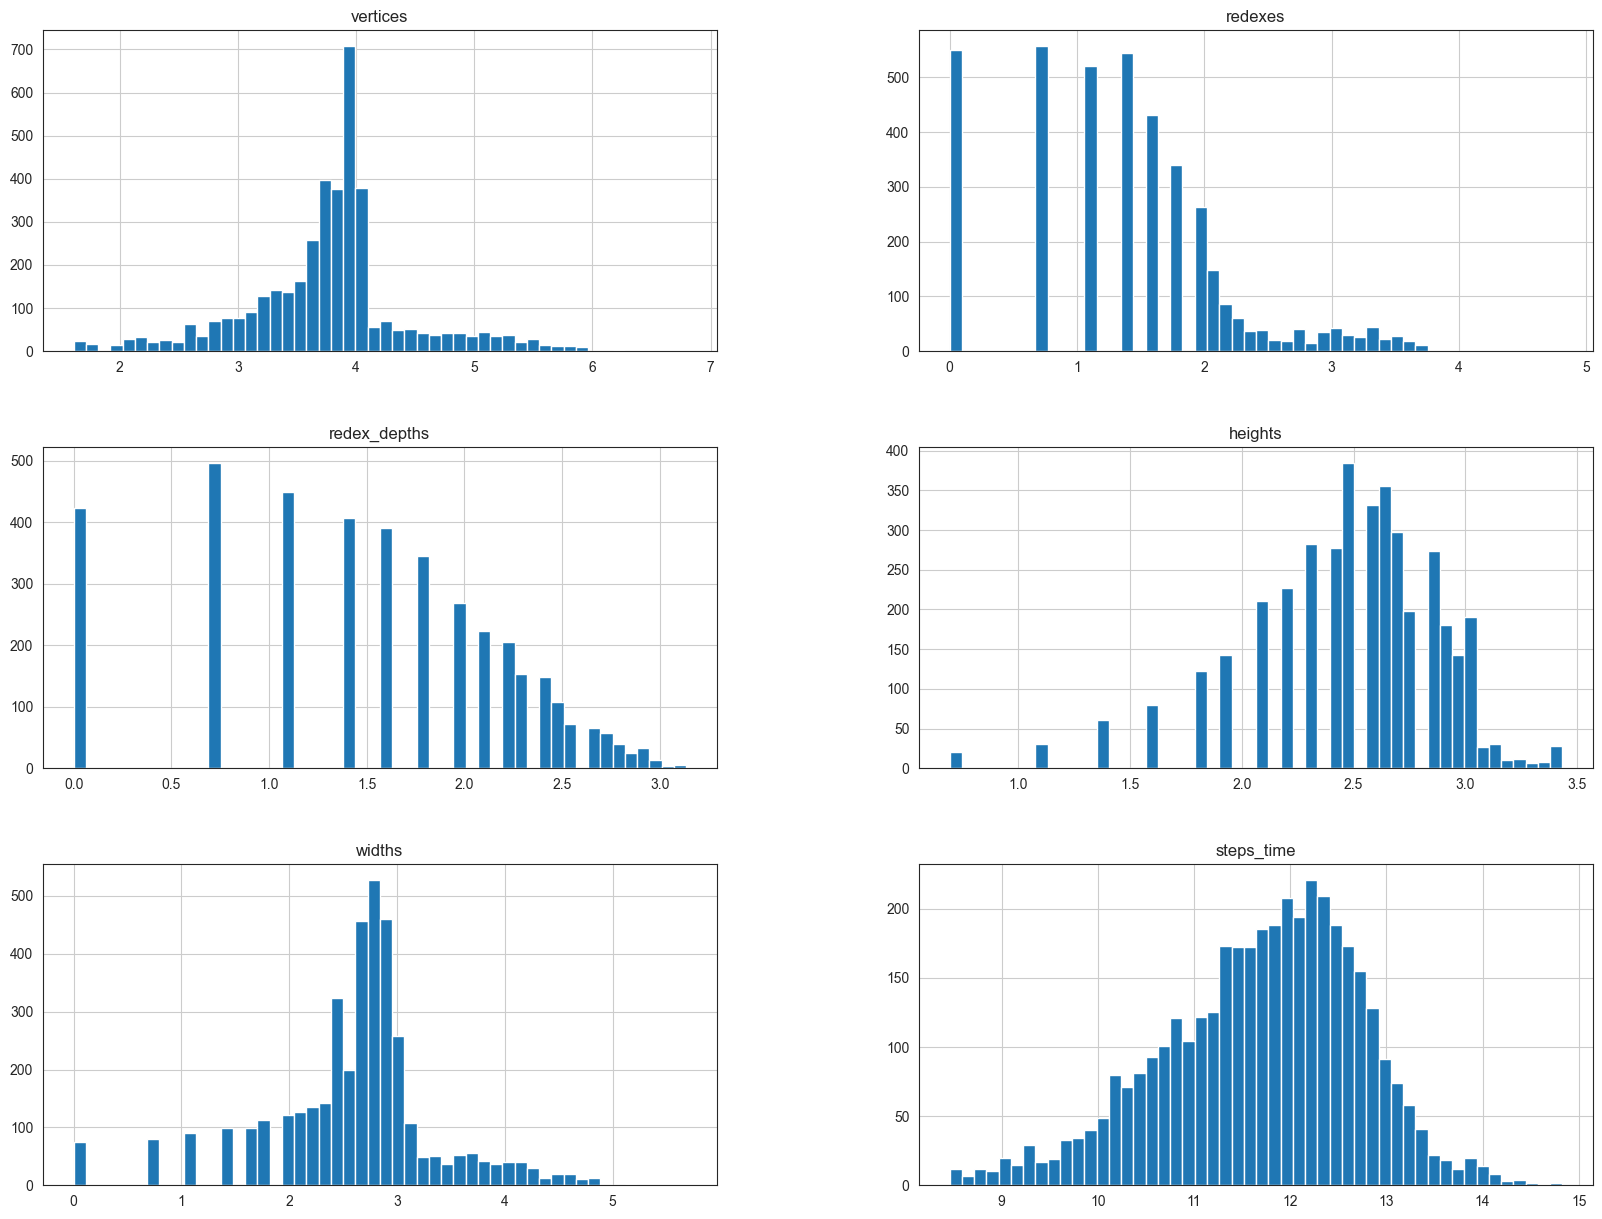

In [14]:
data_log = pd.DataFrame()
for col_name in ["vertices", "redexes", "redex_depths", "heights", "widths", "steps_time"]:
    data_log[col_name] = np.log(data[col_name])

data_log.hist(bins=50)

In [15]:
data_for_training = data[["vertices", "redexes", "redex_depths", "heights", "widths", "steps_time"]]
# data_for_training = data_log


def split_dataset(dataset, test_ratio=0.3):
    test_indices_filter = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices_filter], dataset[test_indices_filter]


train_ds, test_ds = split_dataset(data_for_training)
print(f"Examples for training {len(train_ds)}")
print(f"Examples for testing {len(test_ds)}")

Examples for training 2769
Examples for testing 1162


In [16]:
x_train, y_train = train_ds[["vertices", "redexes", "redex_depths", "heights", "widths"]], train_ds[["steps_time"]]
x_test, y_test = test_ds[["vertices", "redexes", "redex_depths", "heights", "widths"]], test_ds[["steps_time"]]

In [17]:
x_data, y_data = data_for_training[["vertices", "redexes", "redex_depths", "heights", "widths"]], data_for_training[["steps_time"]]

# Functions for drawing predicted values

In [64]:
rcParams['figure.figsize'] = 10, 12

def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Step Time")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

# 1. Linear Regression

In [65]:
lin_regressor = LinearRegression()
lin_regressor.fit(x_train, y_train)

y_train_pred = lin_regressor.predict(x_train)
y_test_pred = lin_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)

TRAIN Root Mean Squared Error(RMSE): 80898.58588680257
TEST Root Mean Squared Error(RMSE): 78620.66267845996


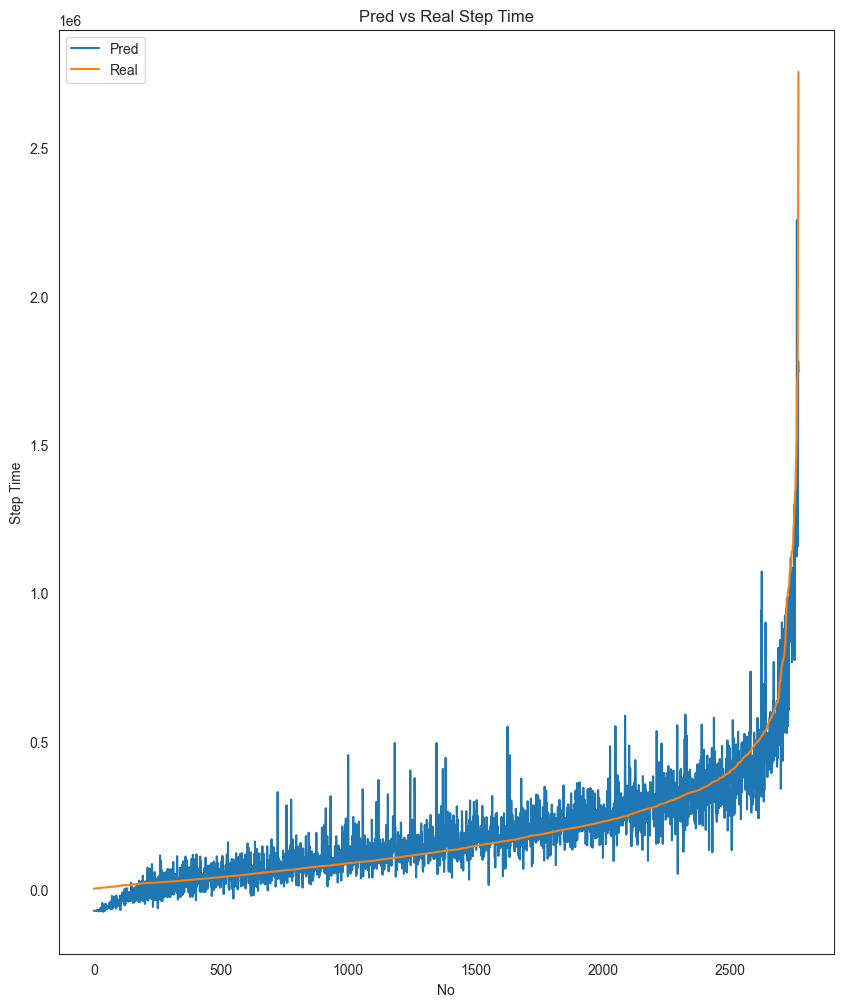

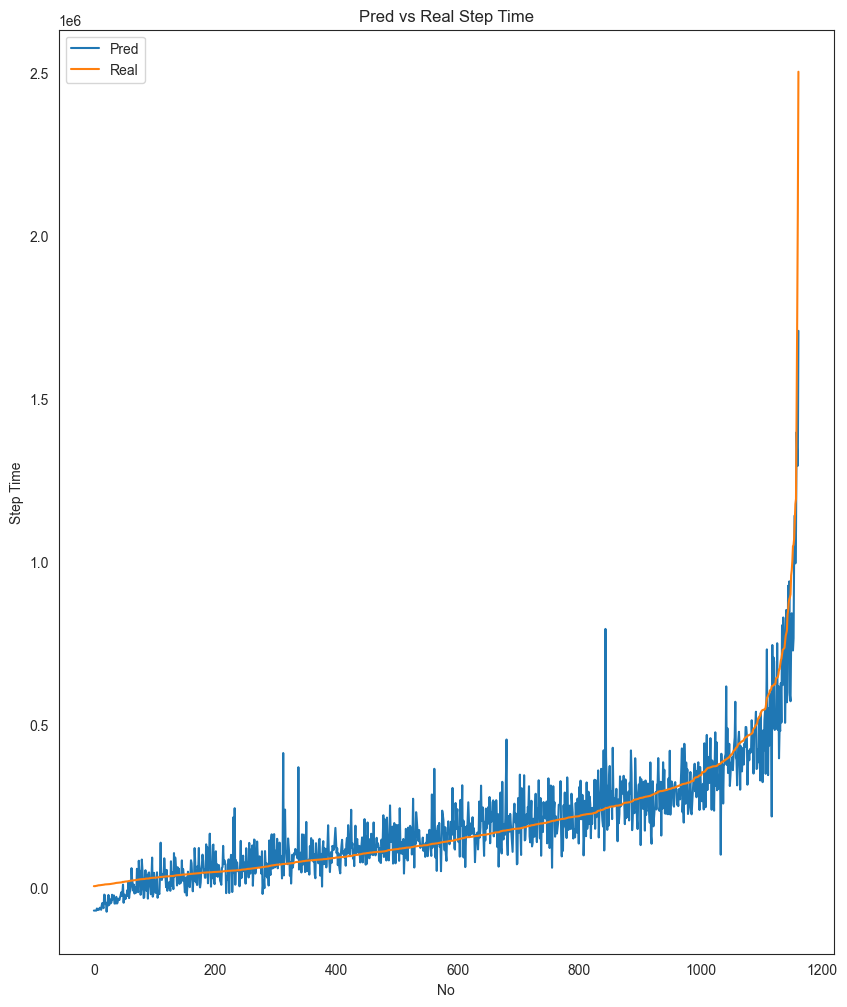

In [66]:
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [67]:
lin_regressor = LinearRegression()
lin_regressor.fit(x_train, y_train)

y_data_pred = lin_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

ALL RMSE: 80231.9673892406


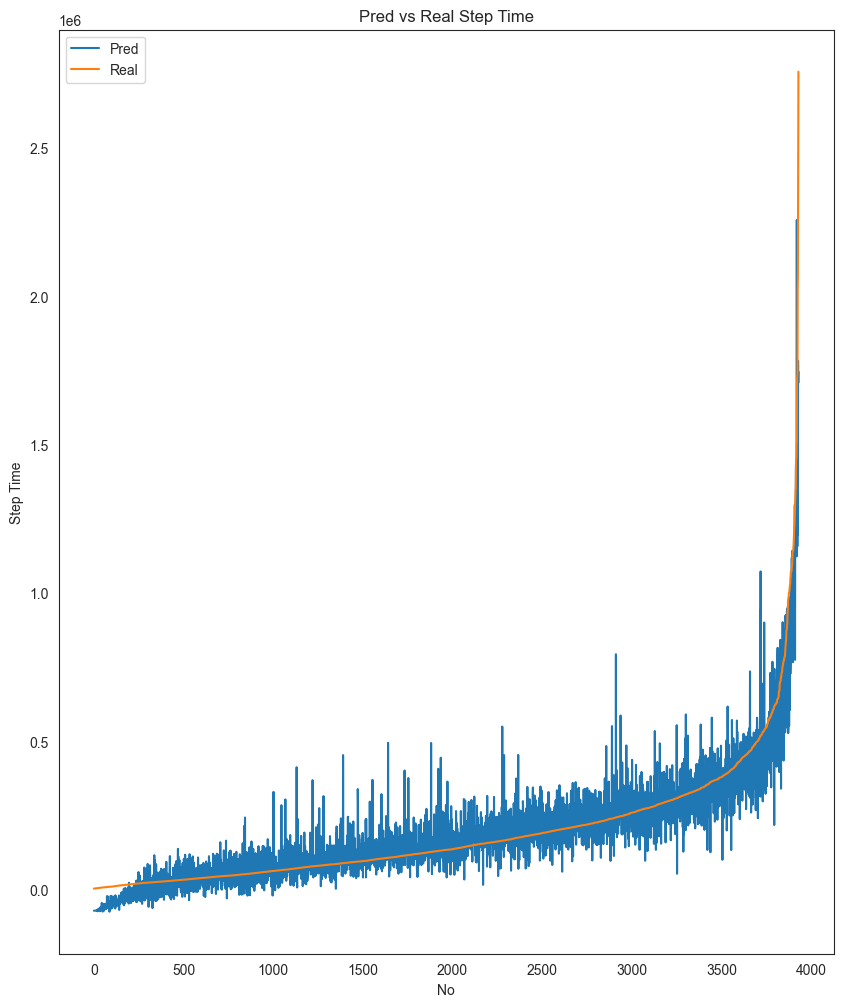

In [68]:
draw_pred_lines(list(y_data_pred[:, -1]), y_data["steps_time"].to_list())

# 2. Decision Tree Regression

In [69]:
dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(x_train, y_train)

y_train_pred = dt_regressor.predict(x_train)
y_test_pred = dt_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)

TRAIN Root Mean Squared Error(RMSE): 4833.759096109106
TEST Root Mean Squared Error(RMSE): 96864.65116585432


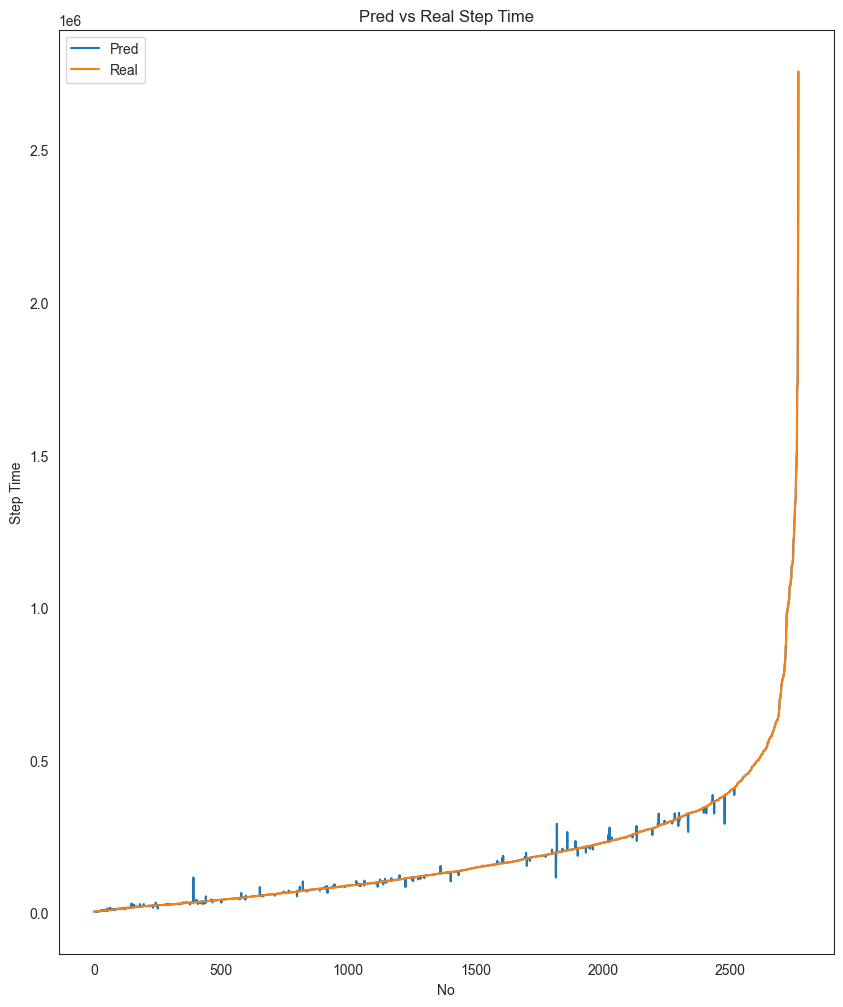

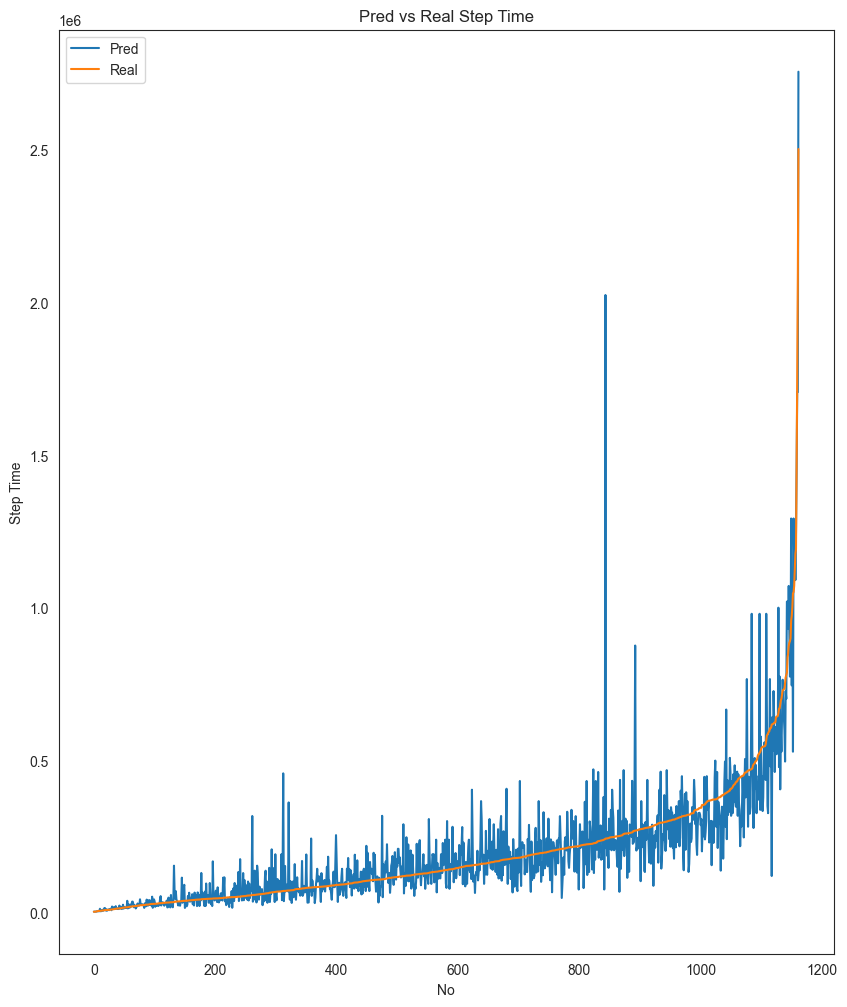

In [70]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

In [71]:
dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(x_train, y_train)

y_data_pred = dt_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

ALL RMSE: 44353.76029879183


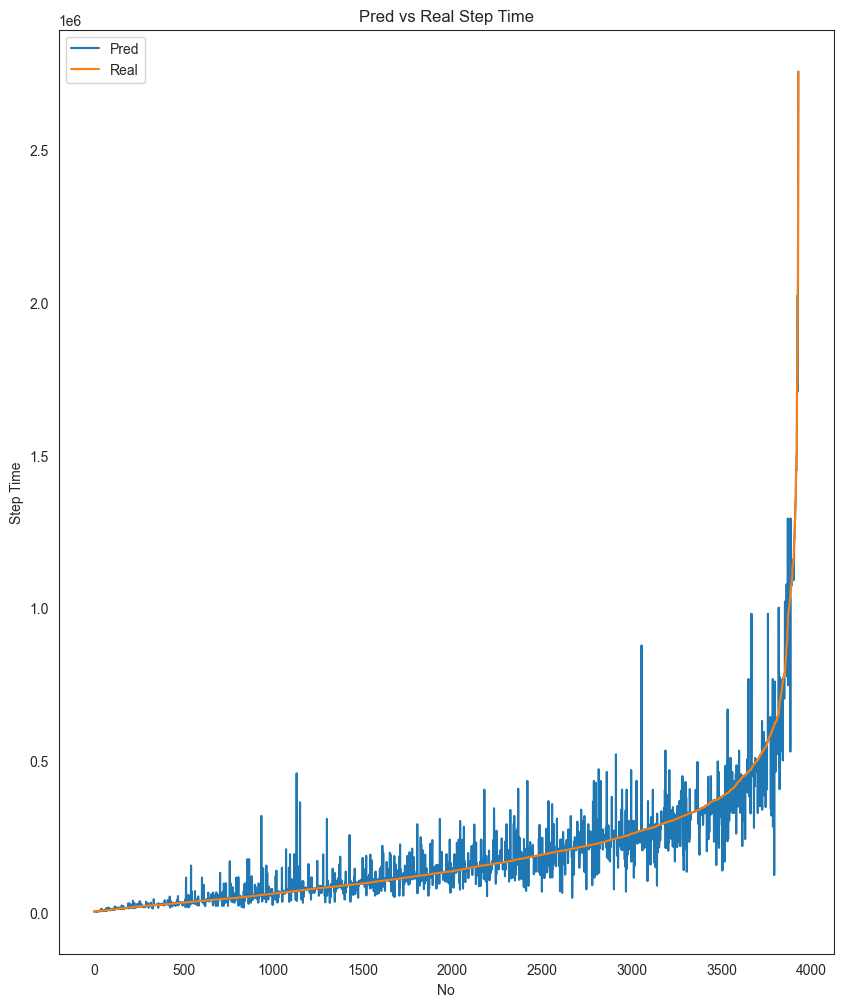

In [72]:
draw_pred_lines(list(y_data_pred), y_data["steps_time"].to_list())

# 3. Random Forest

In [73]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(x_train, y_train)

y_train_pred = rf_regressor.predict(x_train)
y_test_pred = rf_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


TRAIN Root Mean Squared Error(RMSE): 23027.634236691585
TEST Root Mean Squared Error(RMSE): 65948.39282196977


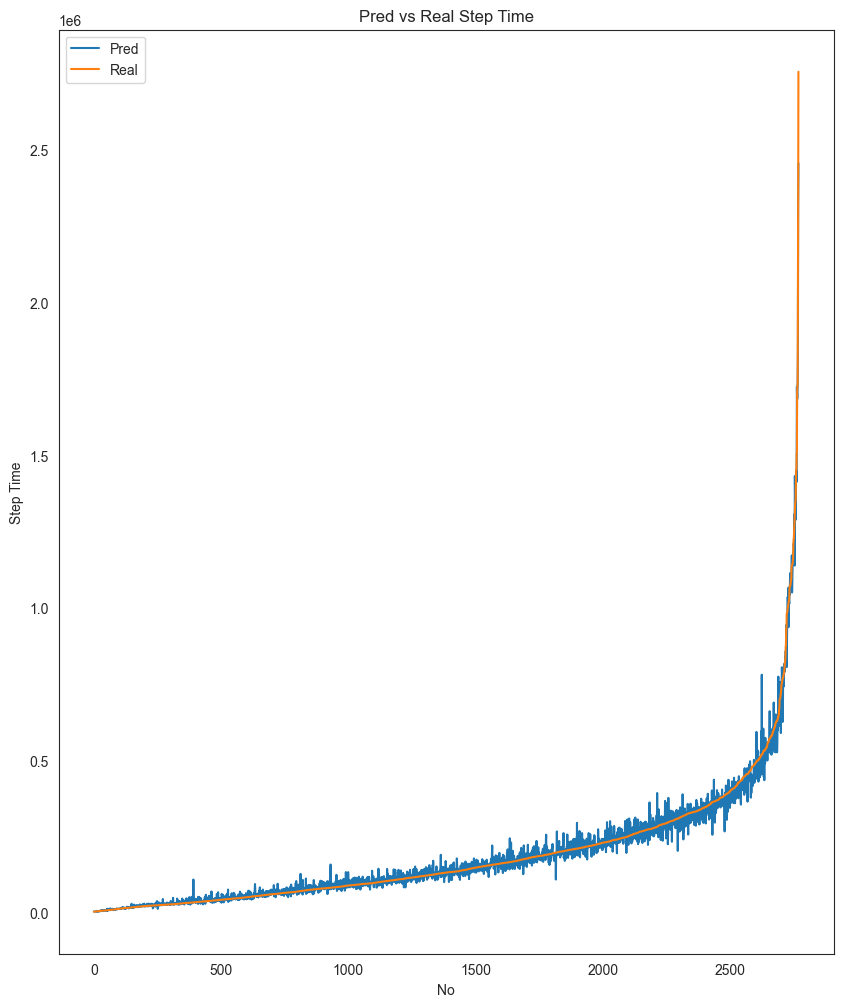

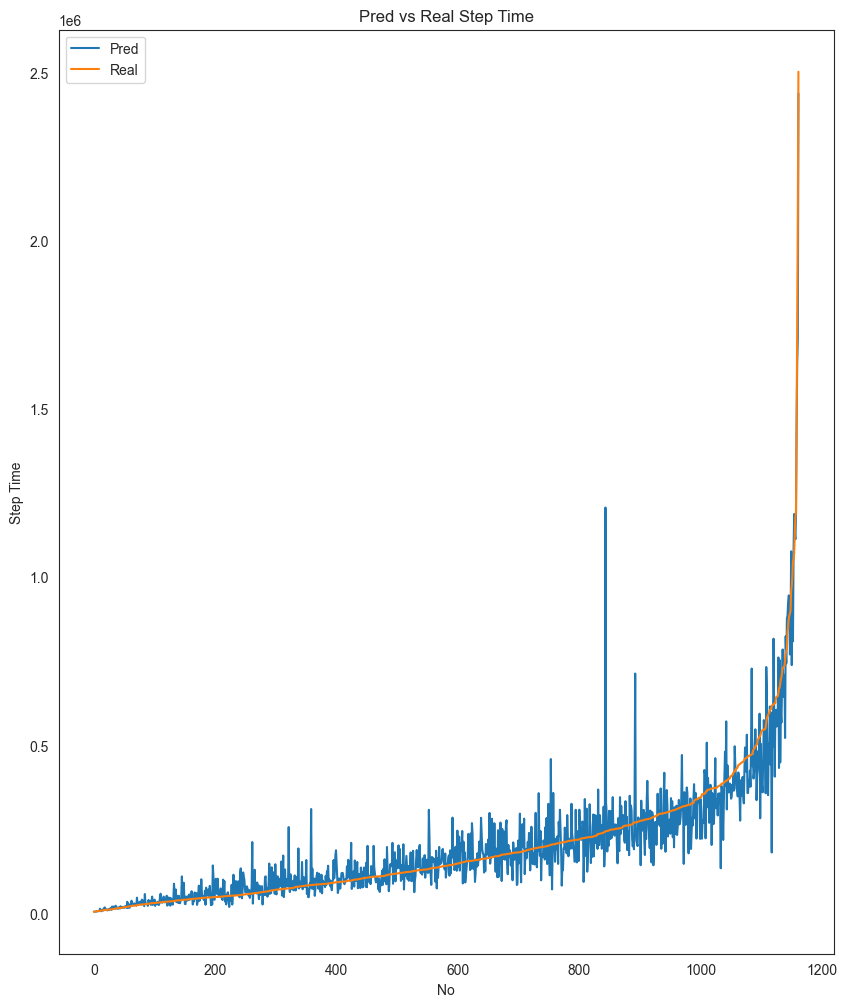

In [74]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

In [75]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(x_data, y_data)

y_data_pred = rf_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ALL RMSE: 22735.624317254435


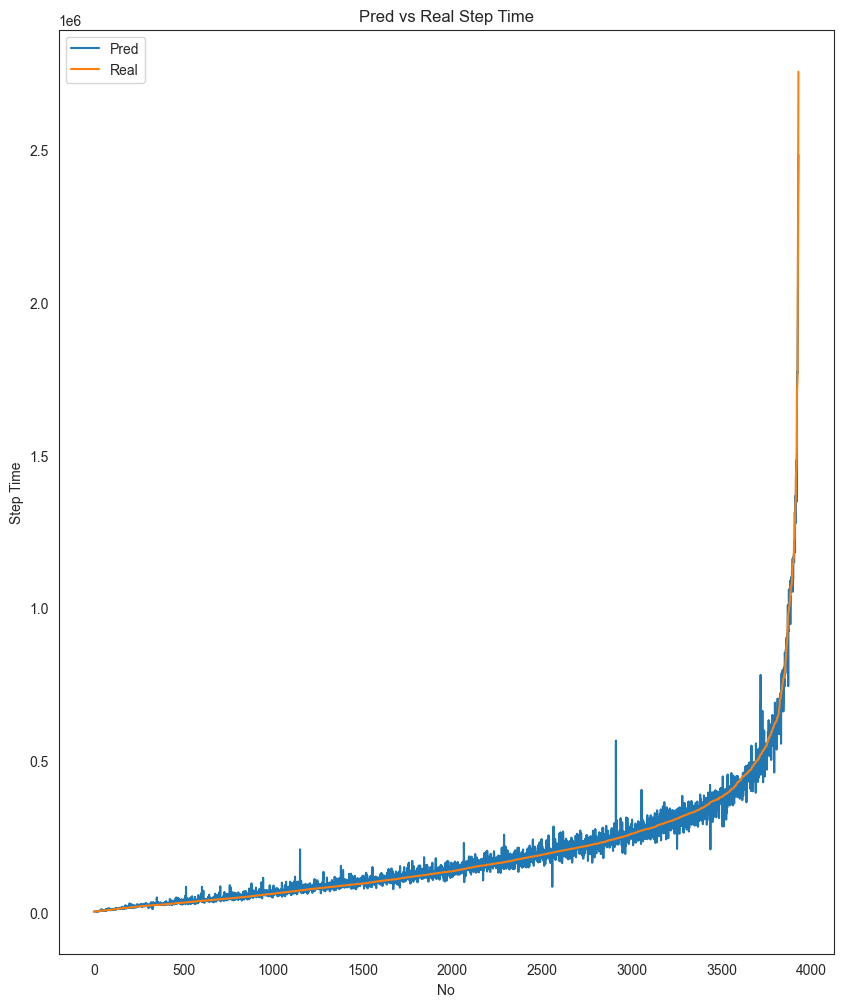

In [76]:
draw_pred_lines(list(y_data_pred), y_data["steps_time"].to_list())

# 4. Support Vector Regression
### kernel='rbf'

In [77]:
svr_regressor = SVR(kernel="rbf")
svr_regressor.fit(x_train, y_train)

y_train_pred = svr_regressor.predict(x_train)
y_test_pred = svr_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN Root Mean Squared Error(RMSE): 218354.50844746153
TEST Root Mean Squared Error(RMSE): 212906.09758039104


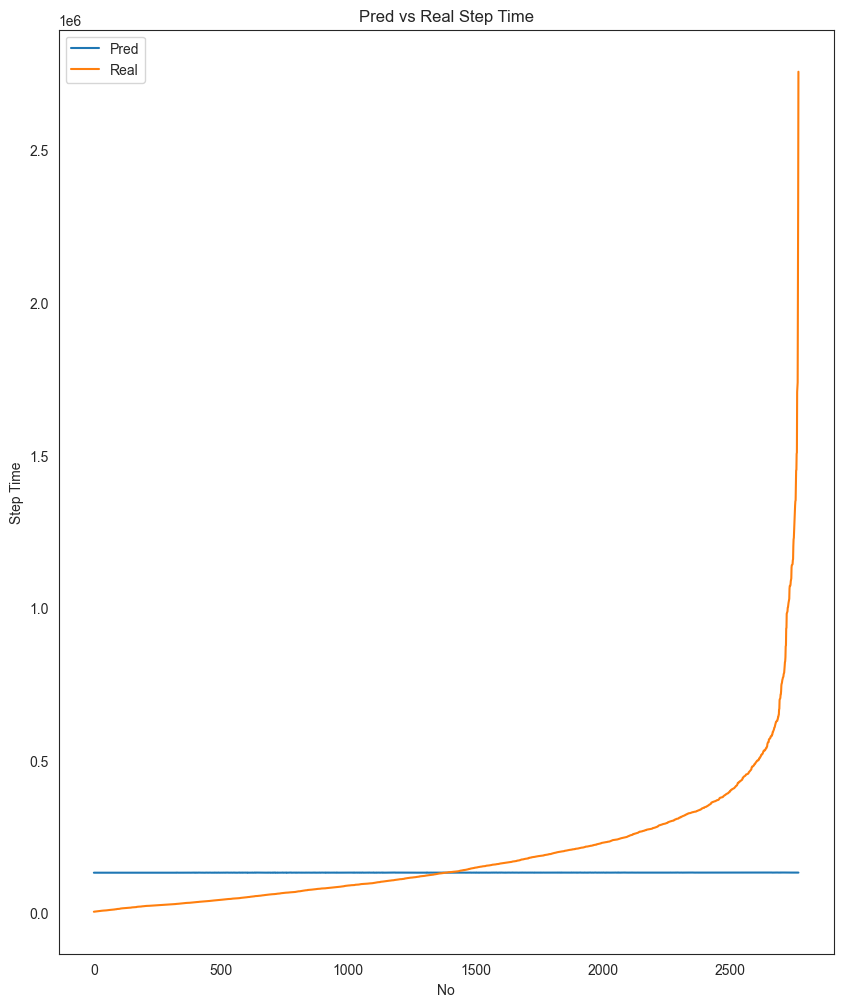

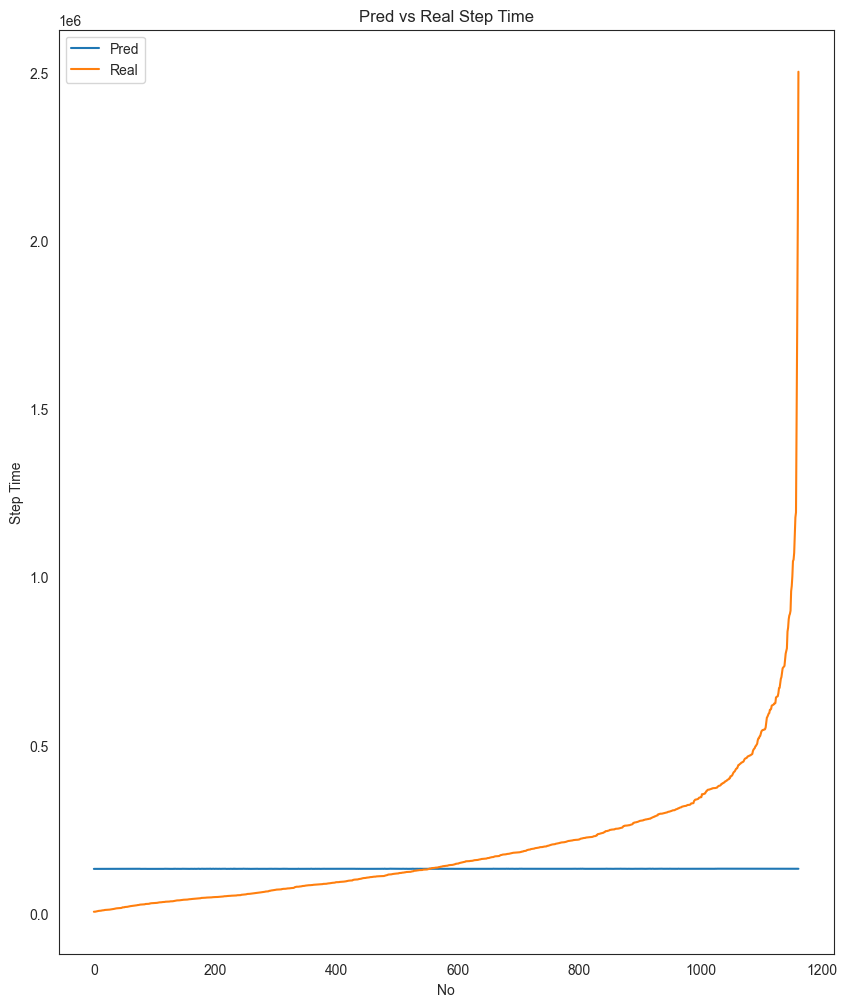

In [78]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

In [79]:
svr_regressor = SVR(kernel="rbf")
svr_regressor.fit(x_data, y_data)

y_data_pred = svr_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ALL RMSE: 216133.33625036874


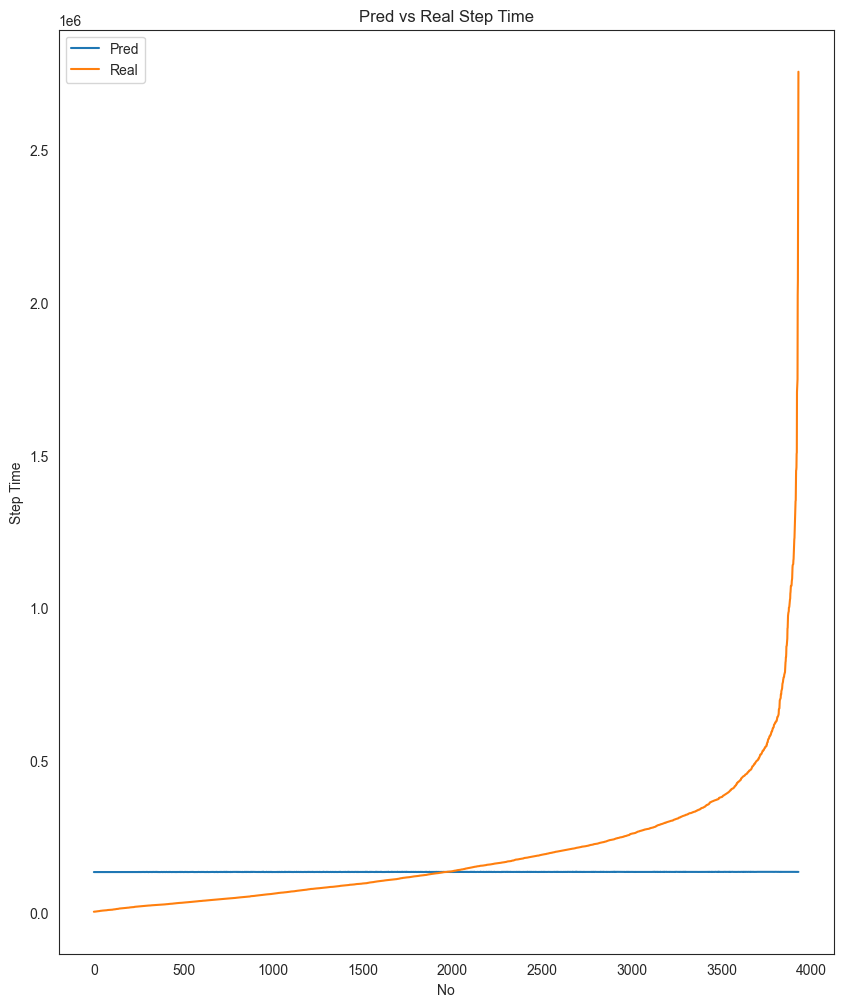

In [80]:
draw_pred_lines(list(y_data_pred), y_data["steps_time"].to_list())

### kernel='linear'

In [81]:
svr_regressor = SVR(kernel="linear")
svr_regressor.fit(x_train, y_train)

y_train_pred = svr_regressor.predict(x_train)
y_test_pred = svr_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)


svr_regressor = SVR(kernel="linear")
svr_regressor.fit(x_data, y_data)

y_data_pred = svr_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN Root Mean Squared Error(RMSE): 115758.84326496162
TEST Root Mean Squared Error(RMSE): 117649.86953069868


D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ALL RMSE: 111159.78524056374


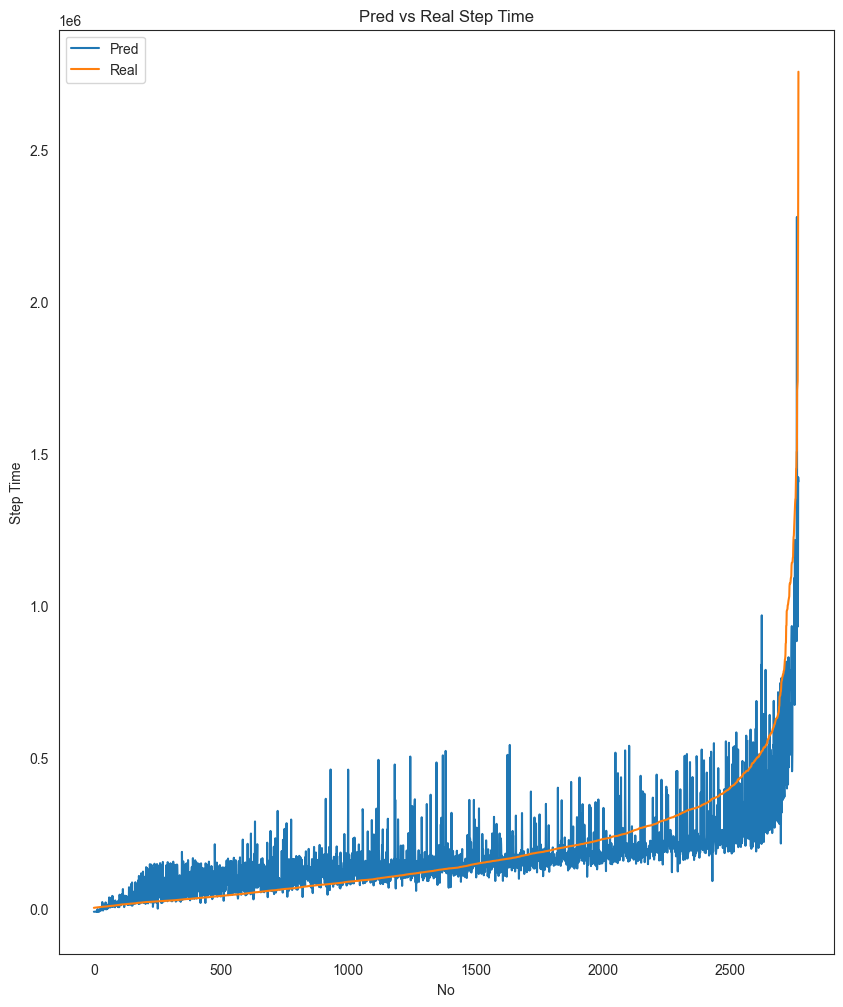

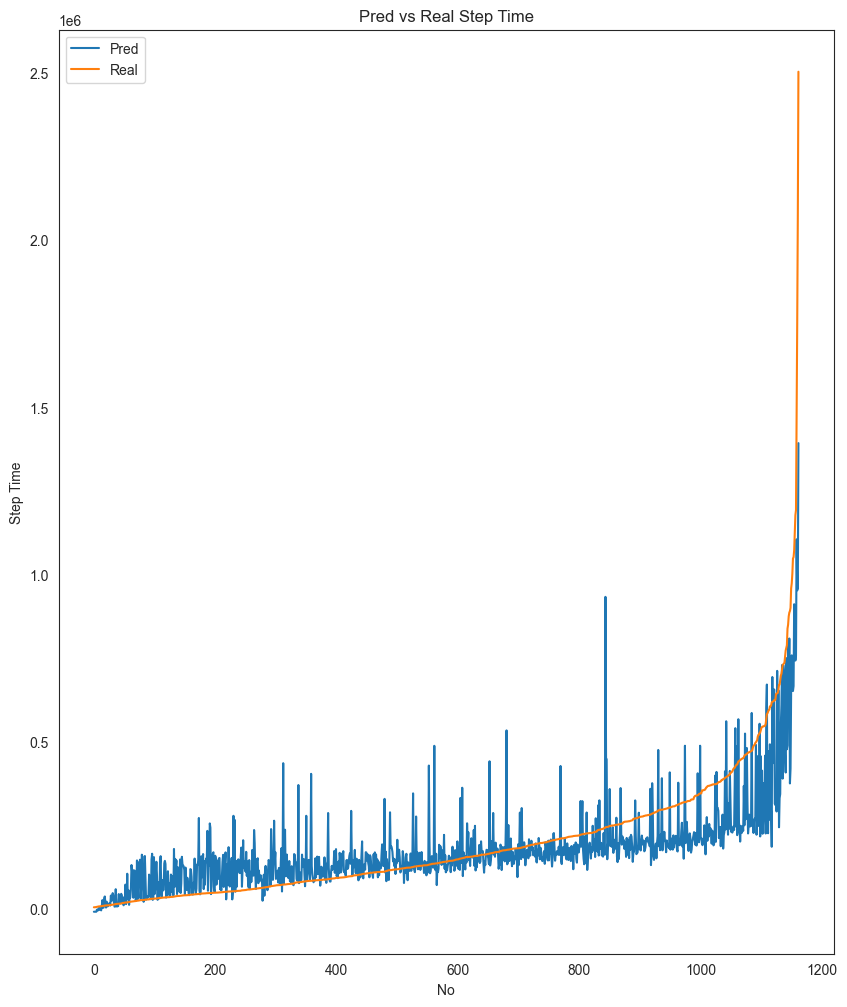

In [82]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

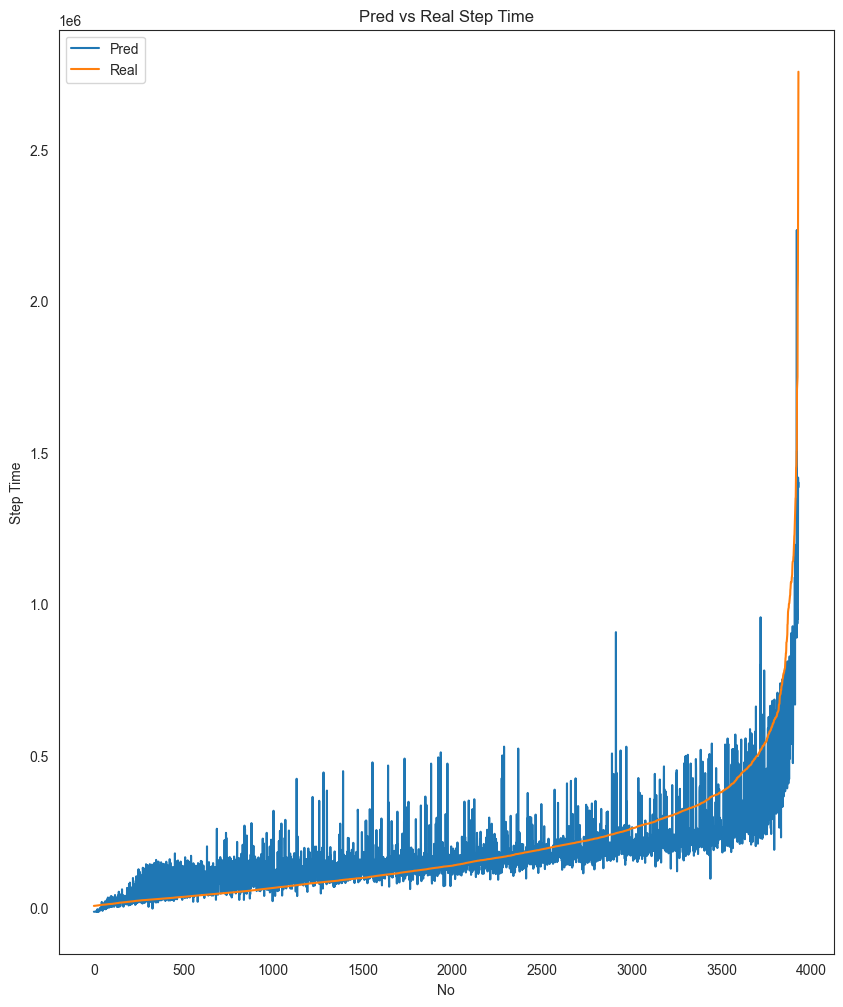

In [83]:
draw_pred_lines(list(y_data_pred), y_data["steps_time"].to_list())

### kernel='poly'

In [ ]:
svr_regressor = SVR(kernel="poly")
svr_regressor.fit(x_train, y_train)

y_train_pred = svr_regressor.predict(x_train)
y_test_pred = svr_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)


svr_regressor = SVR(kernel="poly")
svr_regressor.fit(x_data, y_data)

y_data_pred = svr_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

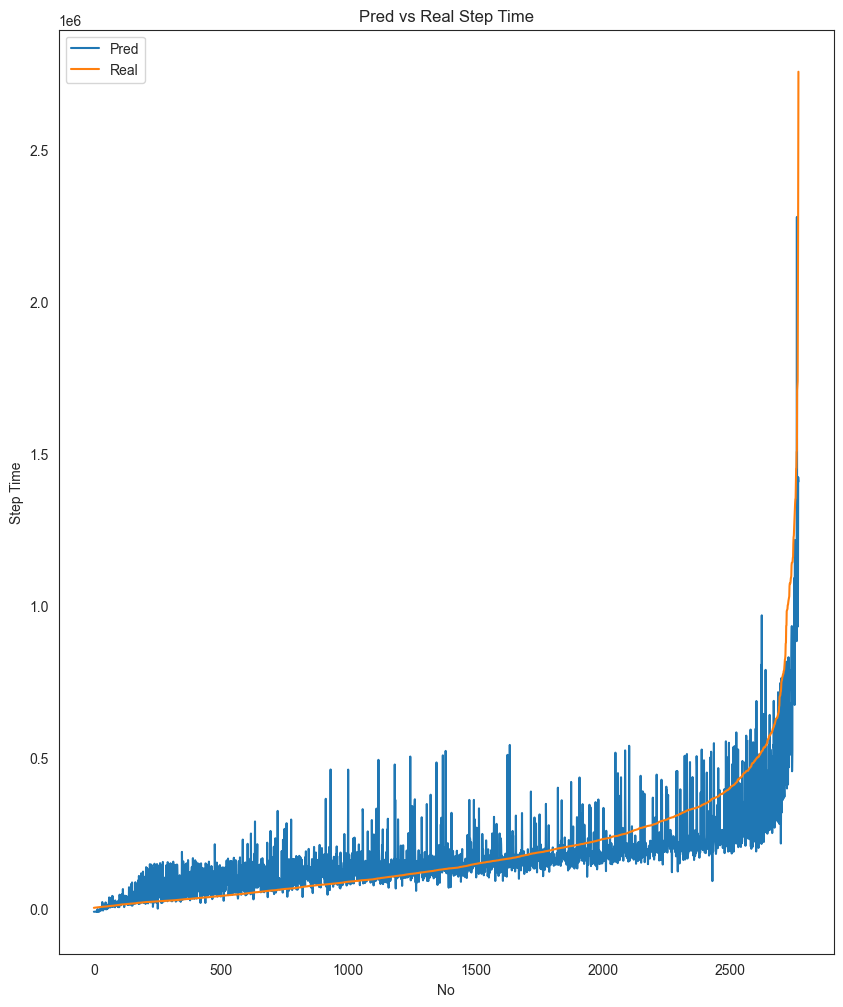

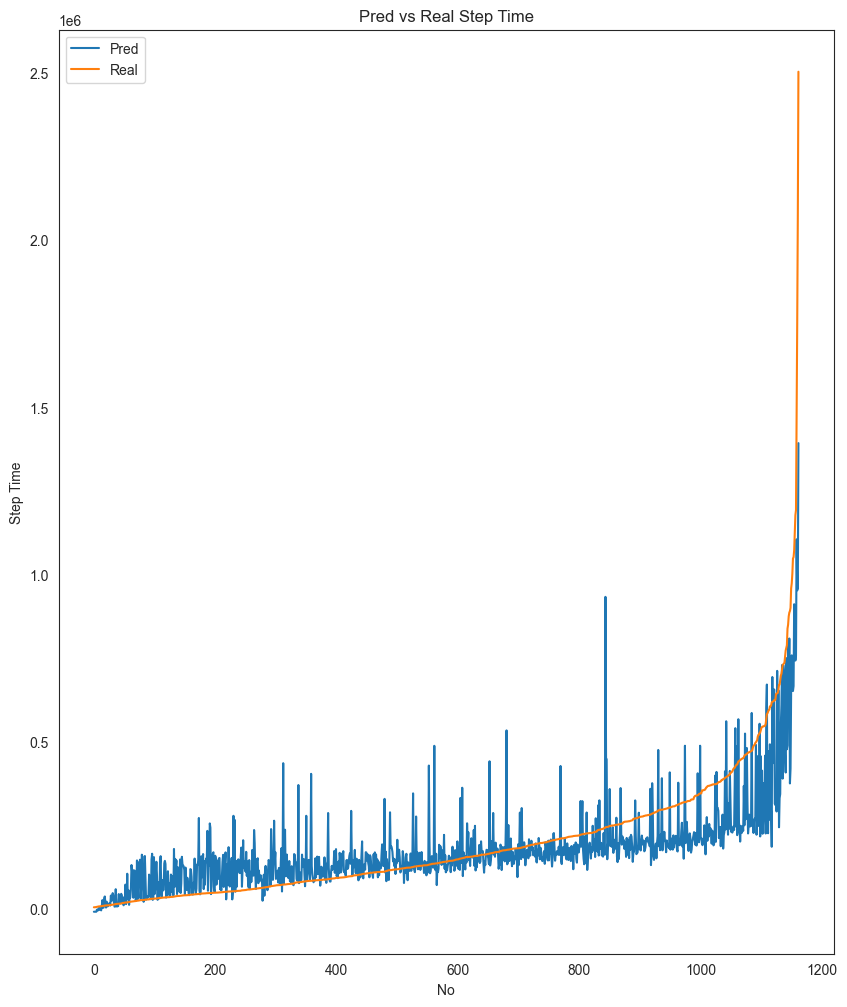

In [84]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

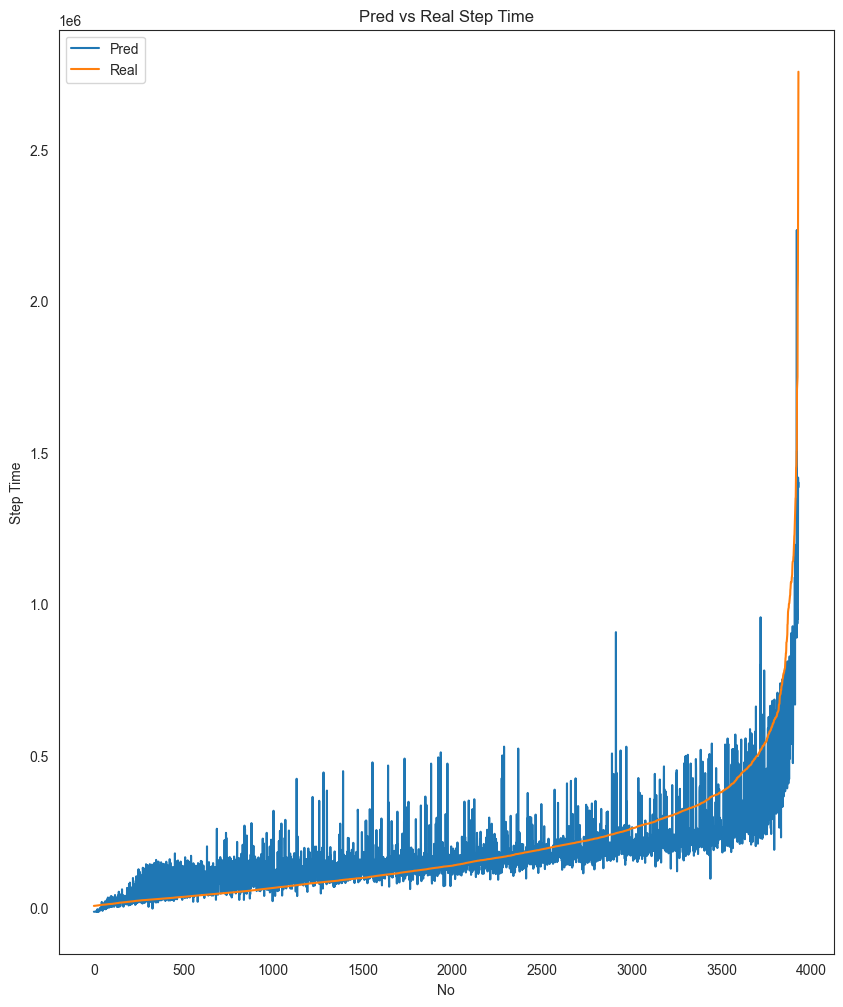

In [85]:
draw_pred_lines(list(y_data_pred), y_data["steps_time"].to_list())

# kernel='sigmoid'

In [86]:
svr_regressor = SVR(kernel="sigmoid")
svr_regressor.fit(x_train, y_train)

y_train_pred = svr_regressor.predict(x_train)
y_test_pred = svr_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)


svr_regressor = SVR(kernel="sigmoid")
svr_regressor.fit(x_data, y_data)

y_data_pred = svr_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN Root Mean Squared Error(RMSE): 218456.54215651477
TEST Root Mean Squared Error(RMSE): 213007.77234231963


D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ALL RMSE: 216256.59127981425


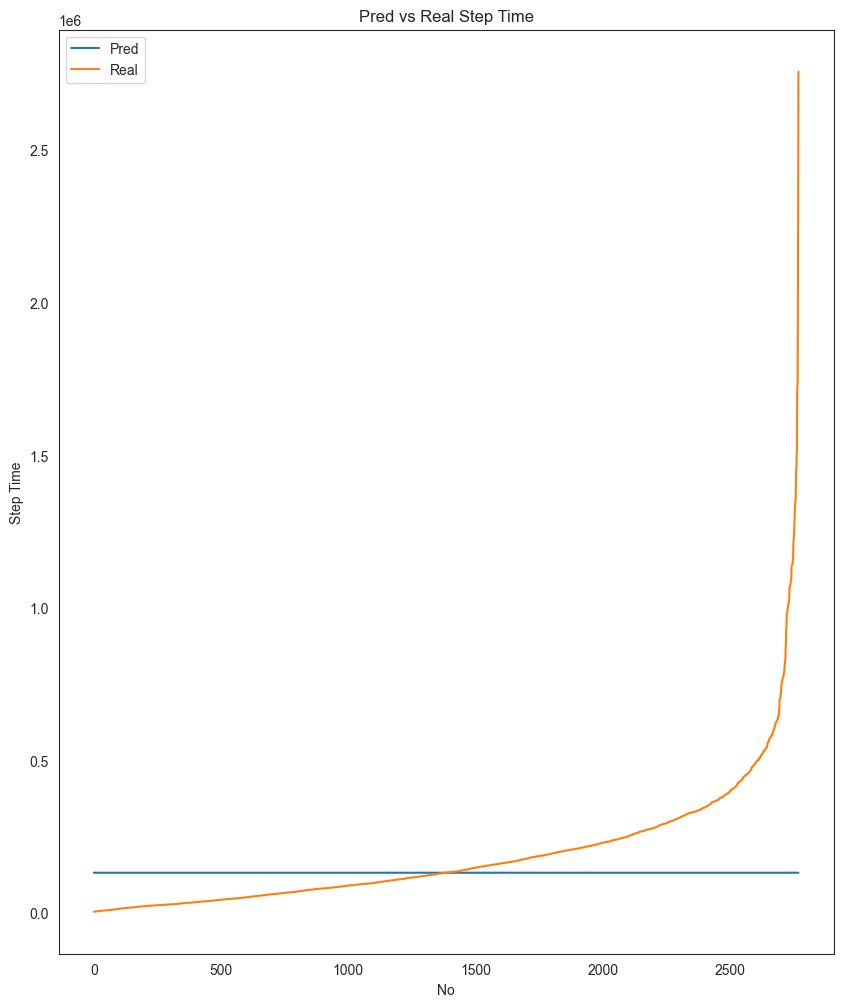

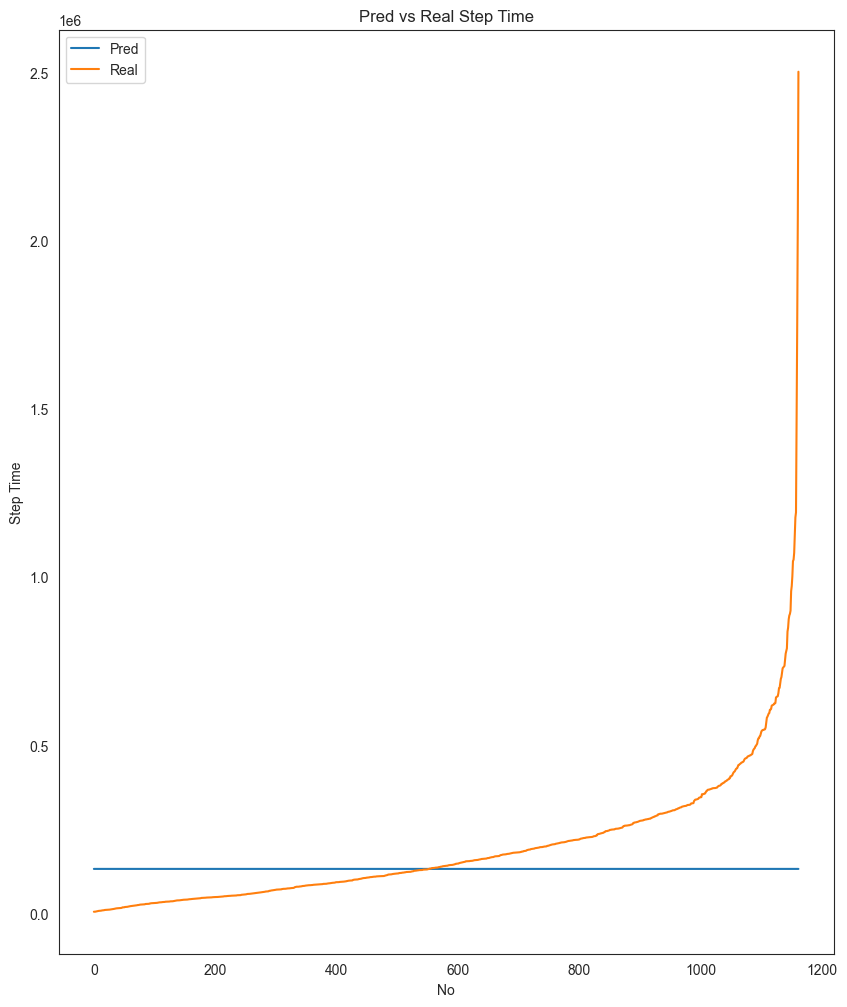

In [88]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

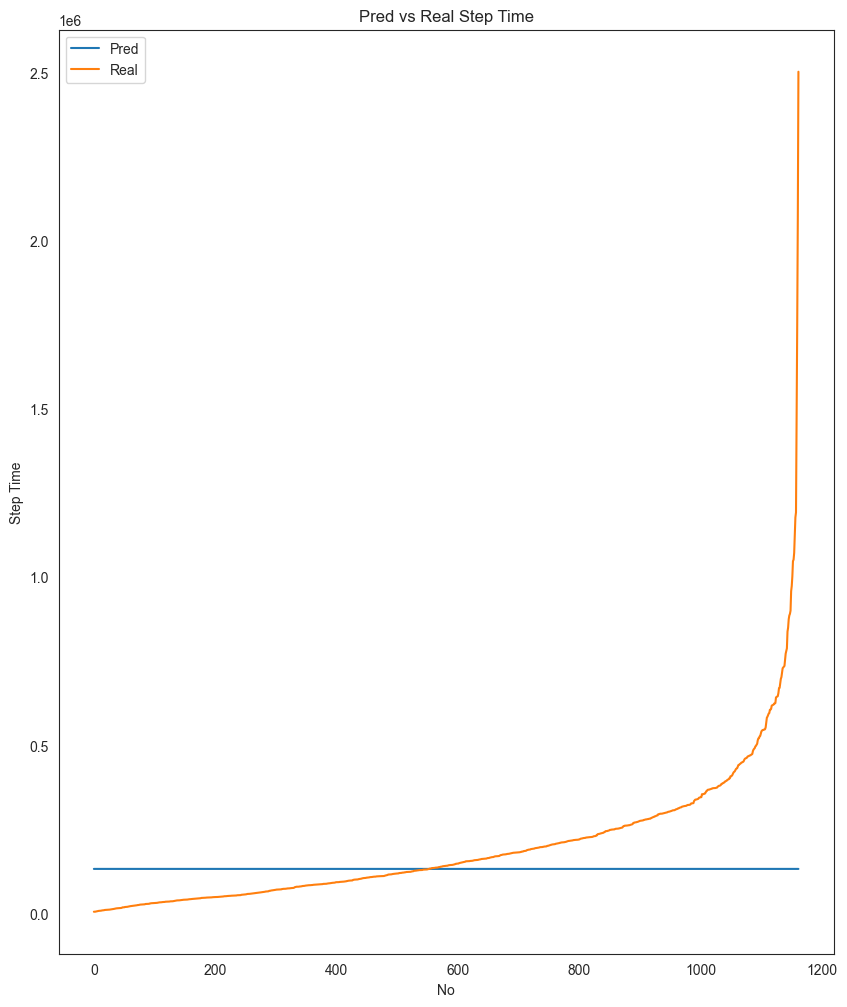

In [89]:
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

# 5. K-Nearest Neighbors Regression

In [90]:
neighbors = 3

knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_train, y_train)

y_train_pred = knn_regressor.predict(x_train)
y_test_pred = knn_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)


knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_data, y_data)

y_data_pred = knn_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

TRAIN Root Mean Squared Error(RMSE): 53339.559025671064
TEST Root Mean Squared Error(RMSE): 73873.65327771466
ALL RMSE: 50540.259677500384


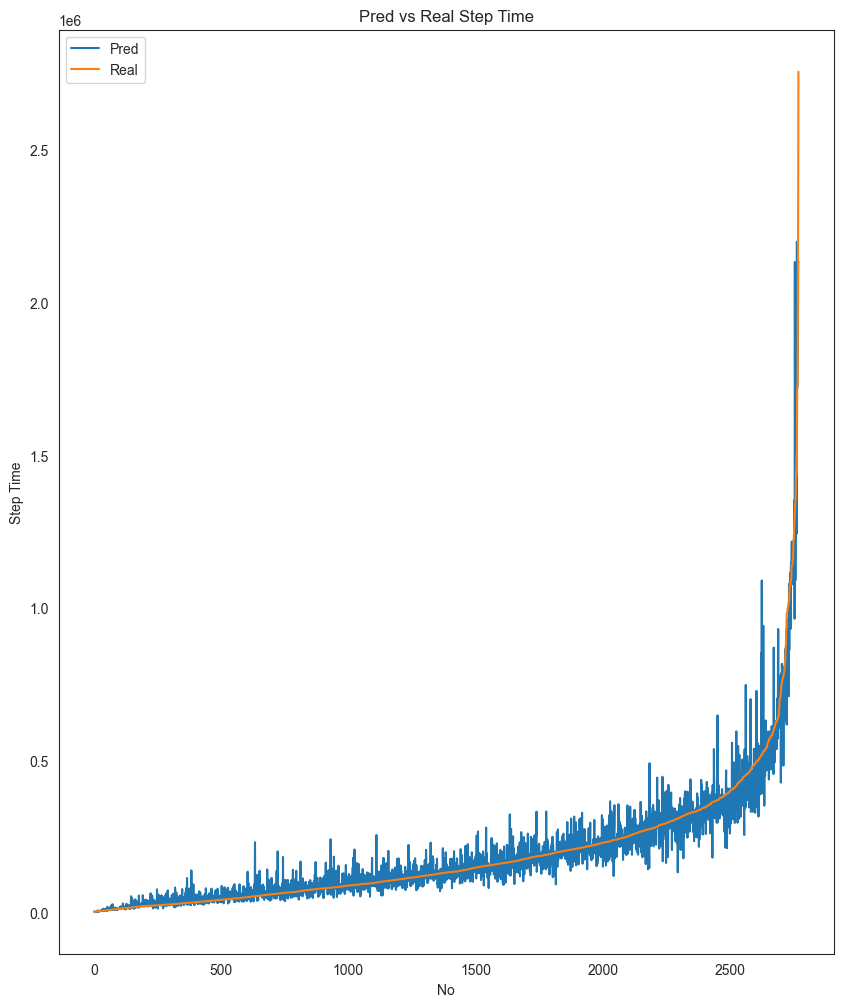

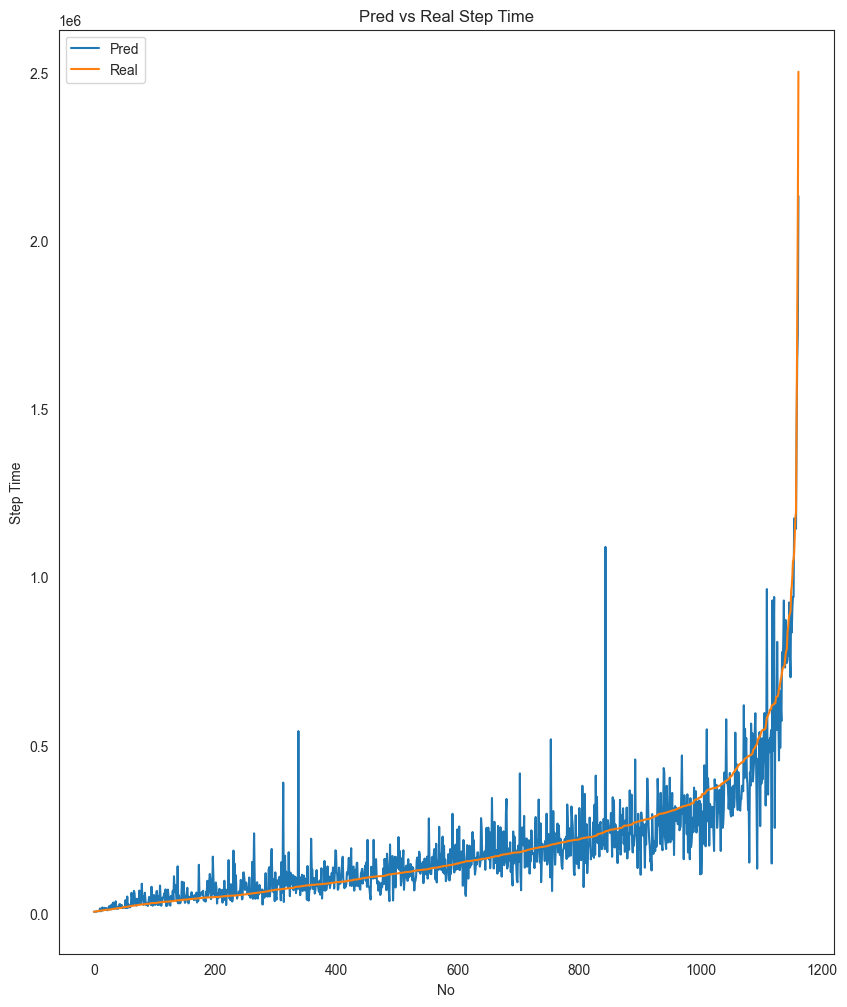

In [91]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

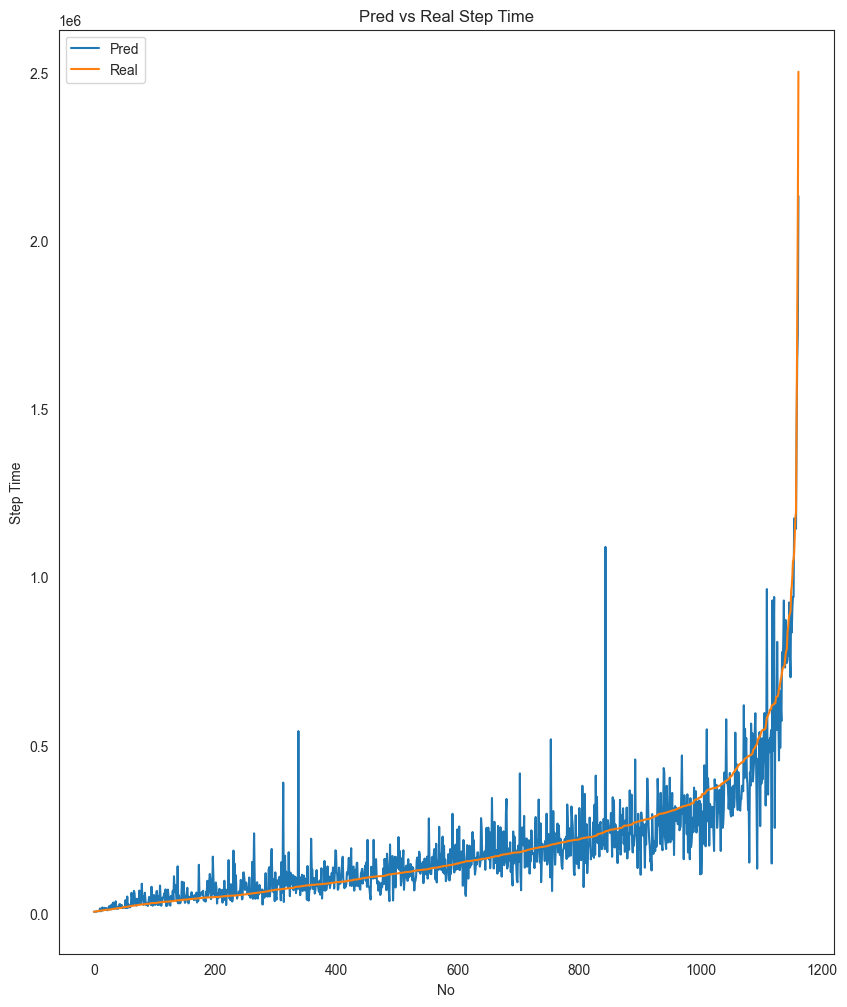

In [92]:
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

In [93]:
neighbors = 6

knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_train, y_train)

y_train_pred = knn_regressor.predict(x_train)
y_test_pred = knn_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)


knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_data, y_data)

y_data_pred = knn_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

TRAIN Root Mean Squared Error(RMSE): 62431.25135149616
TEST Root Mean Squared Error(RMSE): 78159.07386462578
ALL RMSE: 59137.728984598914


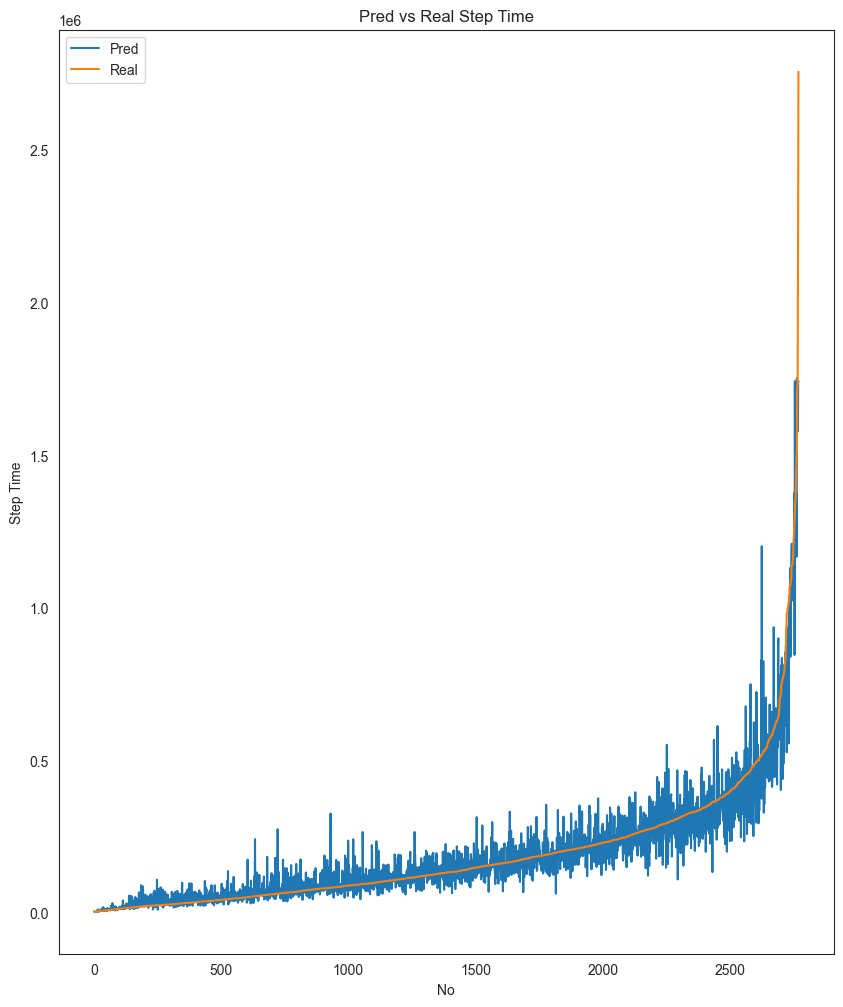

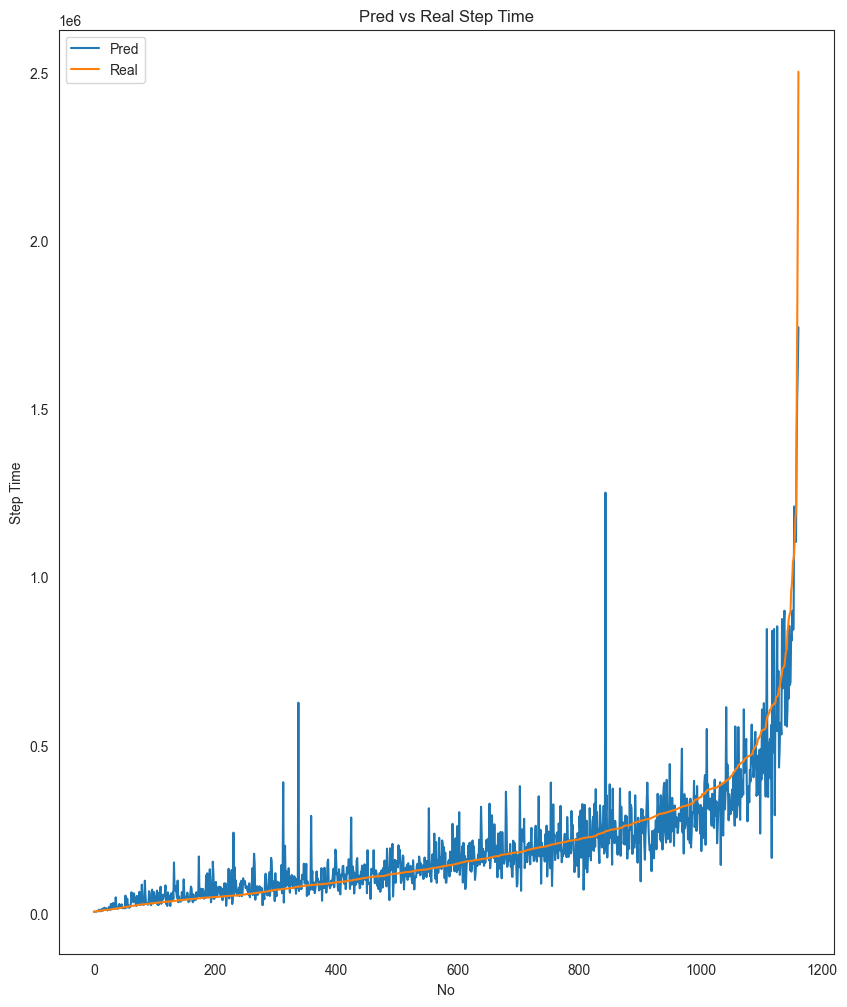

In [96]:
draw_pred_lines(list(y_train_pred), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

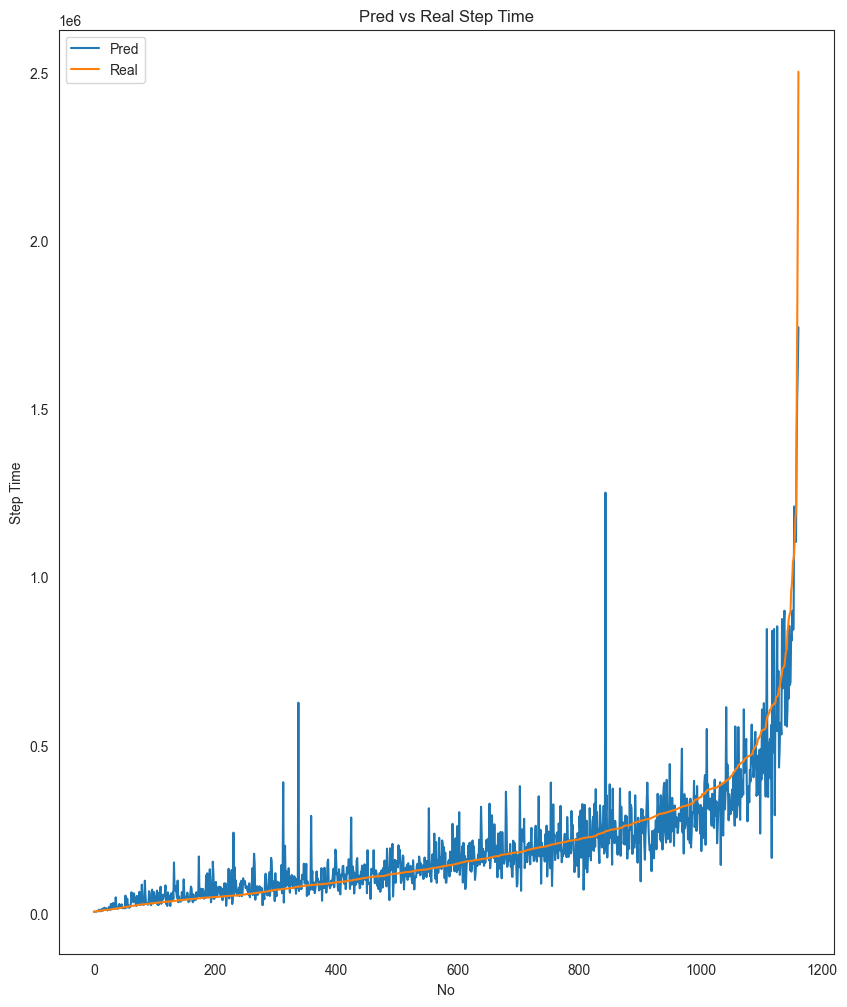

In [98]:
draw_pred_lines(list(y_test_pred), y_test["steps_time"].to_list())

In [99]:
neighbors = 10

knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_train, y_train)

y_train_pred = knn_regressor.predict(x_train)
y_test_pred = knn_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)


knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_data, y_data)

y_data_pred = knn_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

TRAIN Root Mean Squared Error(RMSE): 69840.72584423721
TEST Root Mean Squared Error(RMSE): 84630.58693137494
ALL RMSE: 67084.09018225392


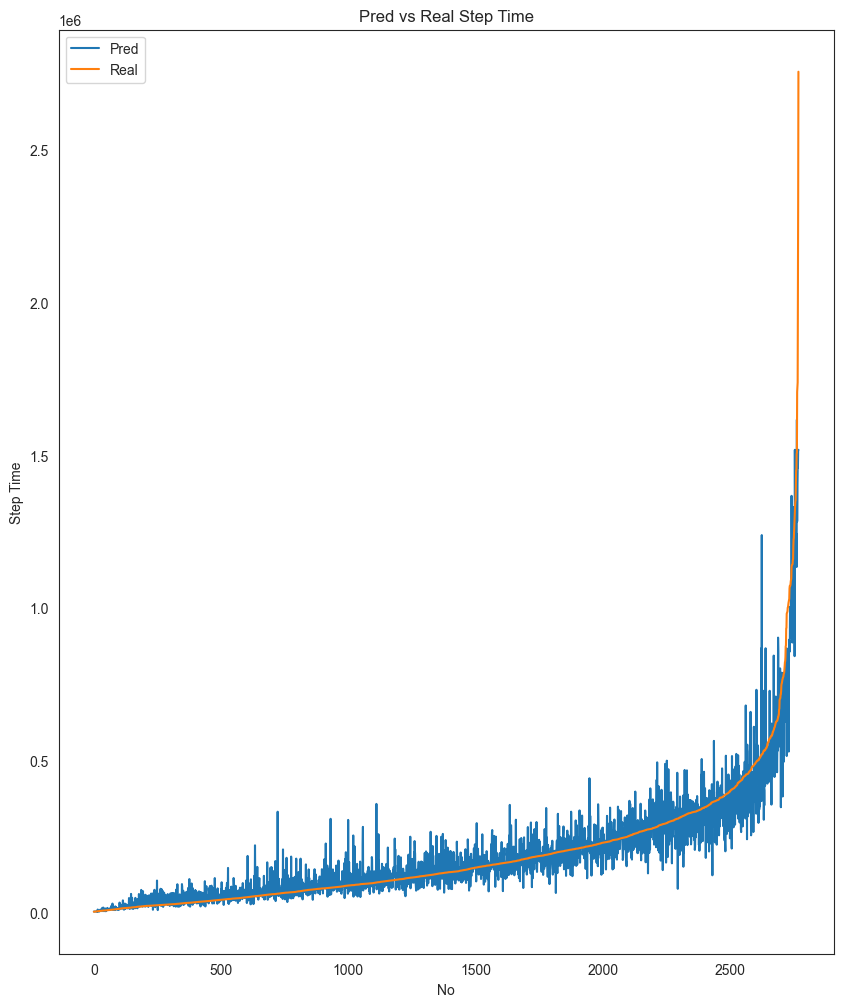

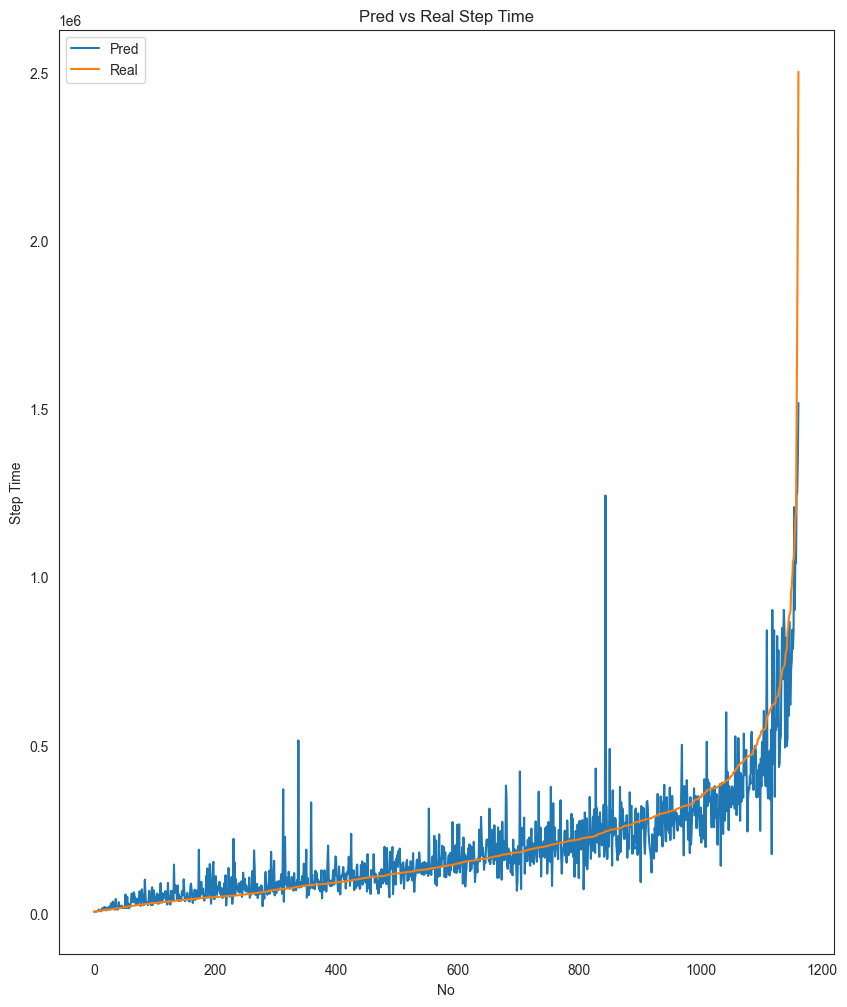

In [100]:
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

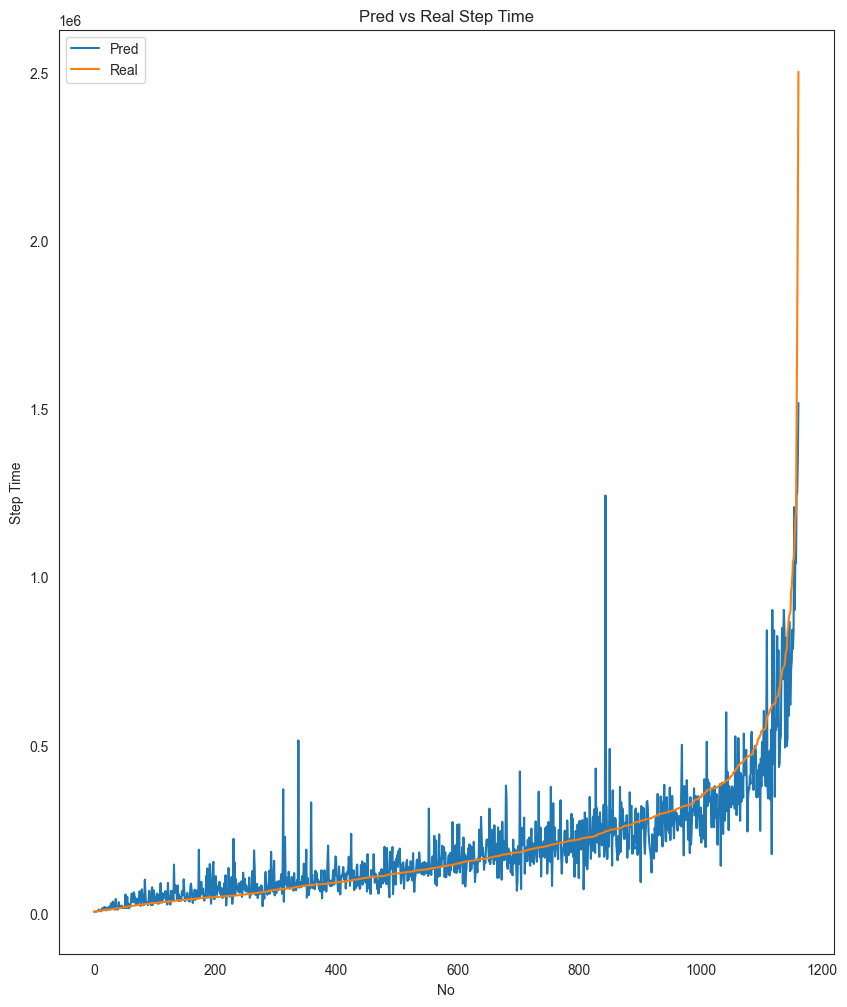

In [101]:
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [102]:
neighbors = 20

knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_train, y_train)

y_train_pred = knn_regressor.predict(x_train)
y_test_pred = knn_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)


knn_regressor = KNeighborsRegressor(n_neighbors=neighbors)
knn_regressor.fit(x_data, y_data)

y_data_pred = knn_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

TRAIN Root Mean Squared Error(RMSE): 80699.29423032906
TEST Root Mean Squared Error(RMSE): 90883.79918263108
ALL RMSE: 78989.00851104624


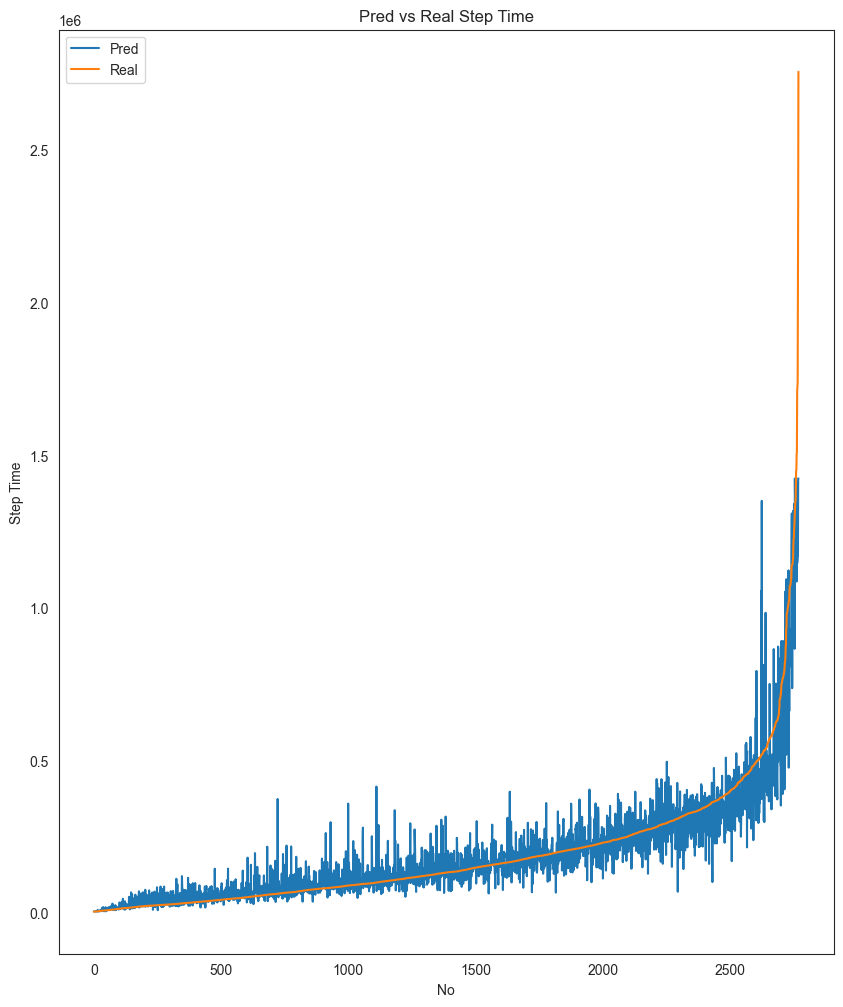

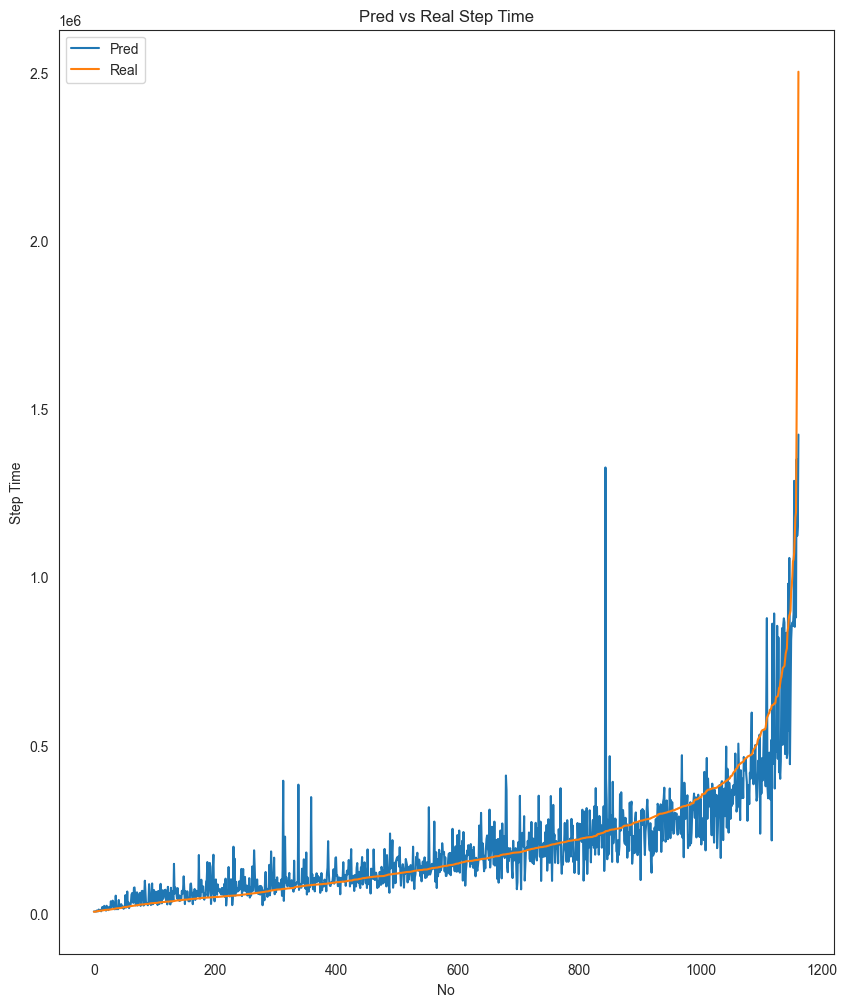

In [103]:
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

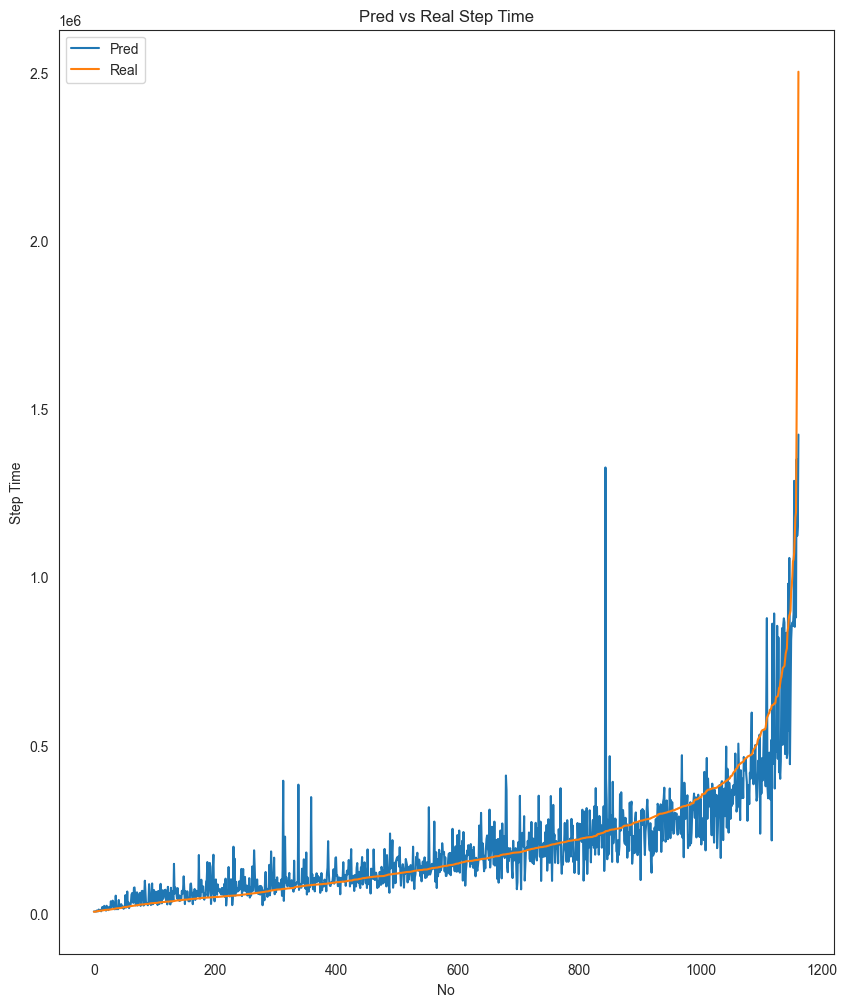

In [104]:
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

# 6. ANN Regression

In [127]:
model = Sequential()
model.add(Dense(units=10, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10_000, batch_size=300)

Epoch 1/10000
10/10 [==============================] - 0s 12ms/step - loss: 80678133760.0000 - val_loss: 79741501440.0000
Epoch 2/10000
10/10 [==============================] - 0s 4ms/step - loss: 80674627584.0000 - val_loss: 79738789888.0000
Epoch 3/10000
10/10 [==============================] - 0s 4ms/step - loss: 80671940608.0000 - val_loss: 79736225792.0000
Epoch 4/10000
10/10 [==============================] - 0s 4ms/step - loss: 80669360128.0000 - val_loss: 79733792768.0000
Epoch 5/10000
10/10 [==============================] - 0s 4ms/step - loss: 80666869760.0000 - val_loss: 79731466240.0000
Epoch 6/10000
10/10 [==============================] - 0s 4ms/step - loss: 80664453120.0000 - val_loss: 79729074176.0000
Epoch 7/10000
10/10 [==============================] - 0s 4ms/step - loss: 80661979136.0000 - val_loss: 79726690304.0000
Epoch 8/10000
10/10 [==============================] - 0s 4ms/step - loss: 80659505152.0000 - val_loss: 79724388352.0000
Epoch 9/10000
10/10 [==========

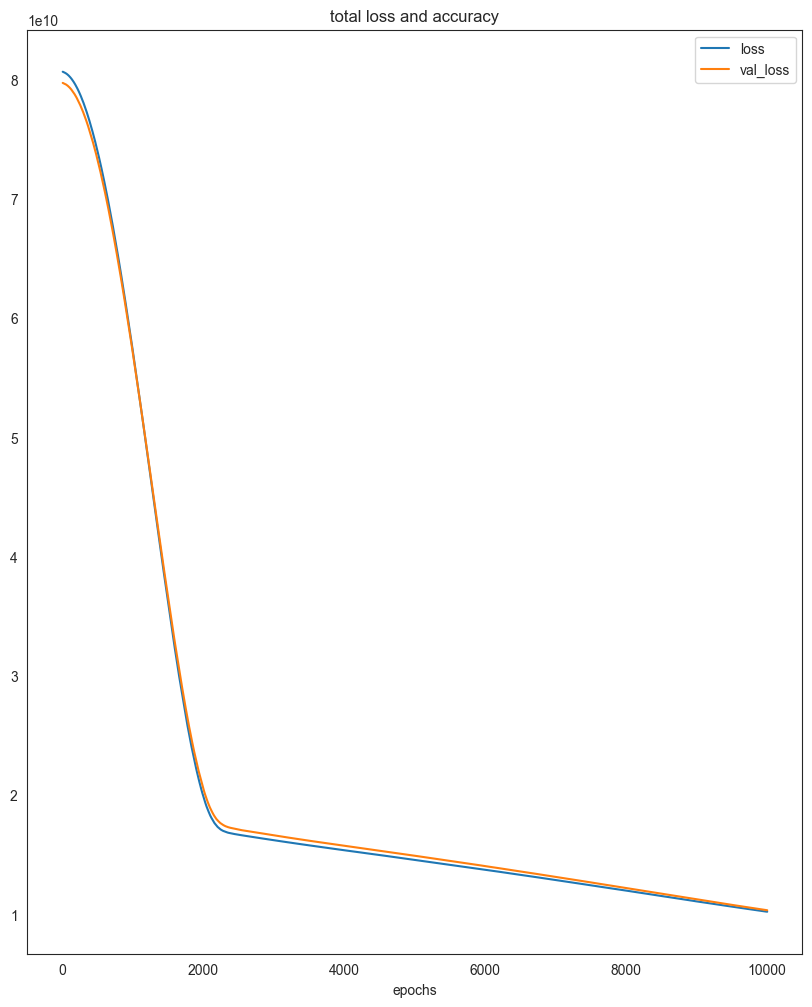

In [128]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label="val_loss")
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

In [129]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)

123/123 [==============================] - 0s 759us/step
TRAIN Root Mean Squared Error(RMSE): 80699.29423032906
TEST Root Mean Squared Error(RMSE): 90883.79918263108
ALL RMSE: 78989.00851104624


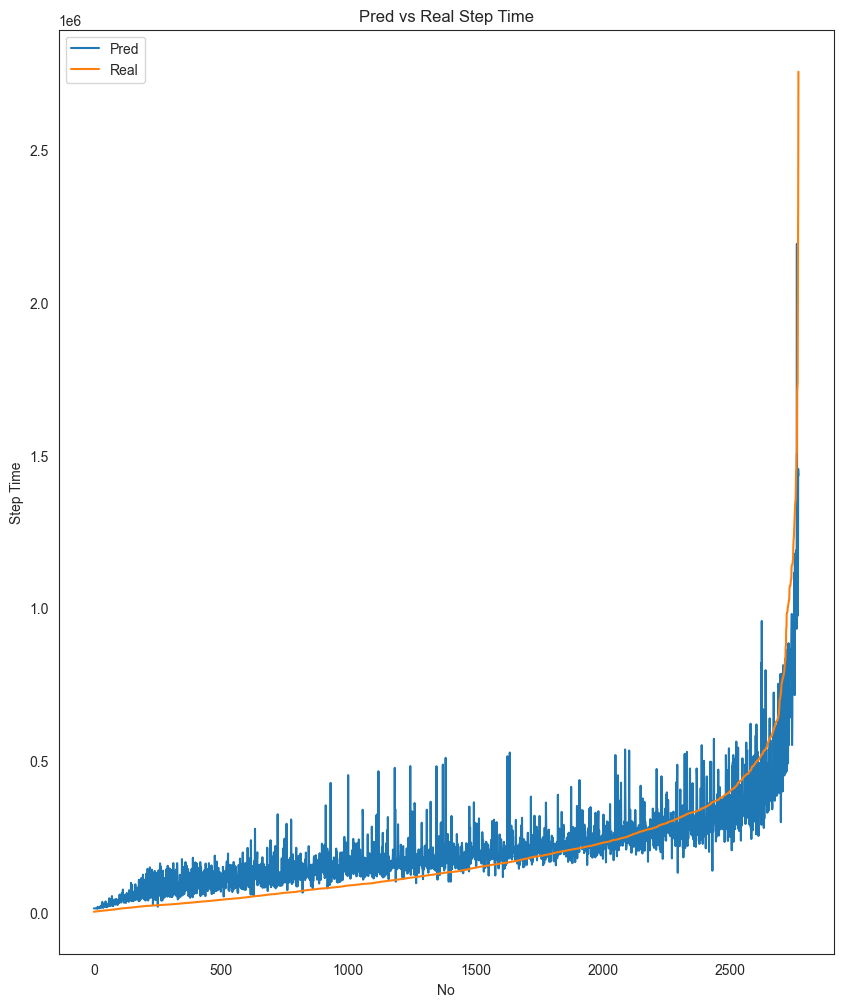

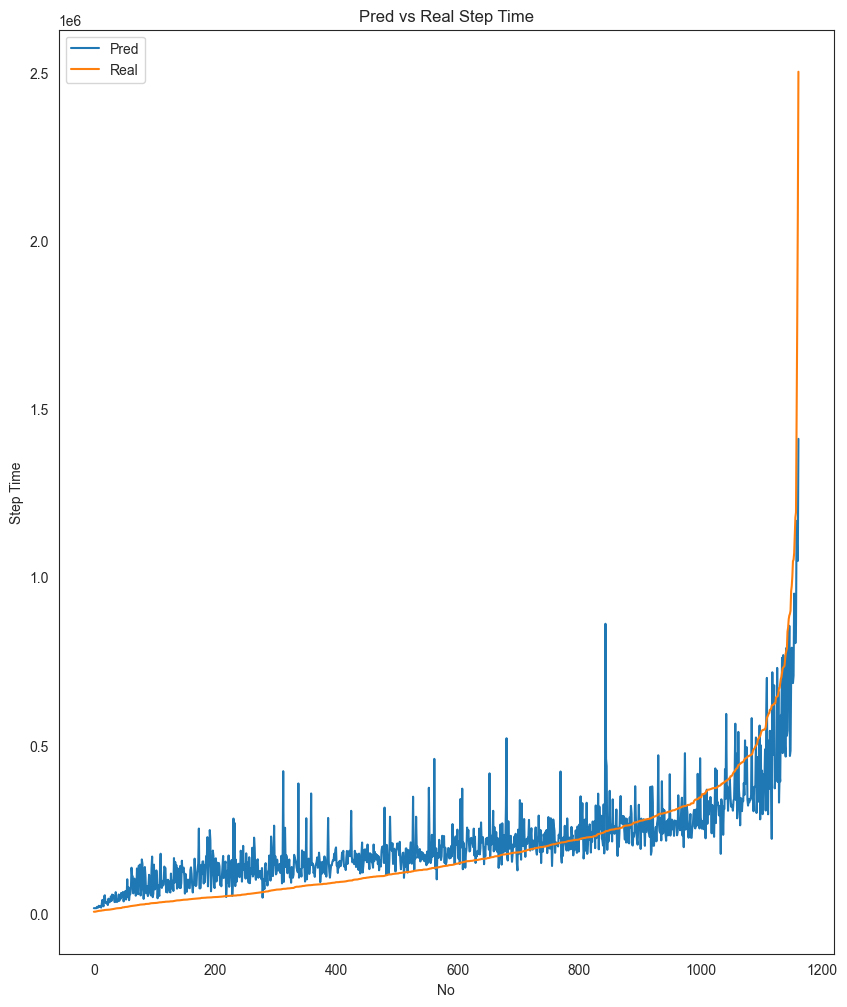

In [130]:
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [133]:
model = Sequential()
model.add(Dense(units=10, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=1)

Epoch 1/100
2769/2769 [==============================] - 4s 1ms/step - loss: 80687931392.0000 - val_loss: 79751340032.0000
Epoch 2/100
2769/2769 [==============================] - 3s 1ms/step - loss: 80685703168.0000 - val_loss: 79750619136.0000
Epoch 3/100
2769/2769 [==============================] - 4s 1ms/step - loss: 80684998656.0000 - val_loss: 79749808128.0000
Epoch 4/100
2769/2769 [==============================] - 3s 1ms/step - loss: 80684253184.0000 - val_loss: 79749062656.0000
Epoch 5/100
2769/2769 [==============================] - 3s 1ms/step - loss: 80641712128.0000 - val_loss: 79628787712.0000
Epoch 6/100
2769/2769 [==============================] - 3s 1ms/step - loss: 80402571264.0000 - val_loss: 79310487552.0000
Epoch 7/100
2769/2769 [==============================] - 4s 1ms/step - loss: 79981207552.0000 - val_loss: 78793695232.0000
Epoch 8/100
2769/2769 [==============================] - 3s 1ms/step - loss: 79354798080.0000 - val_loss: 78099087360.0000
Epoch 9/100
2769

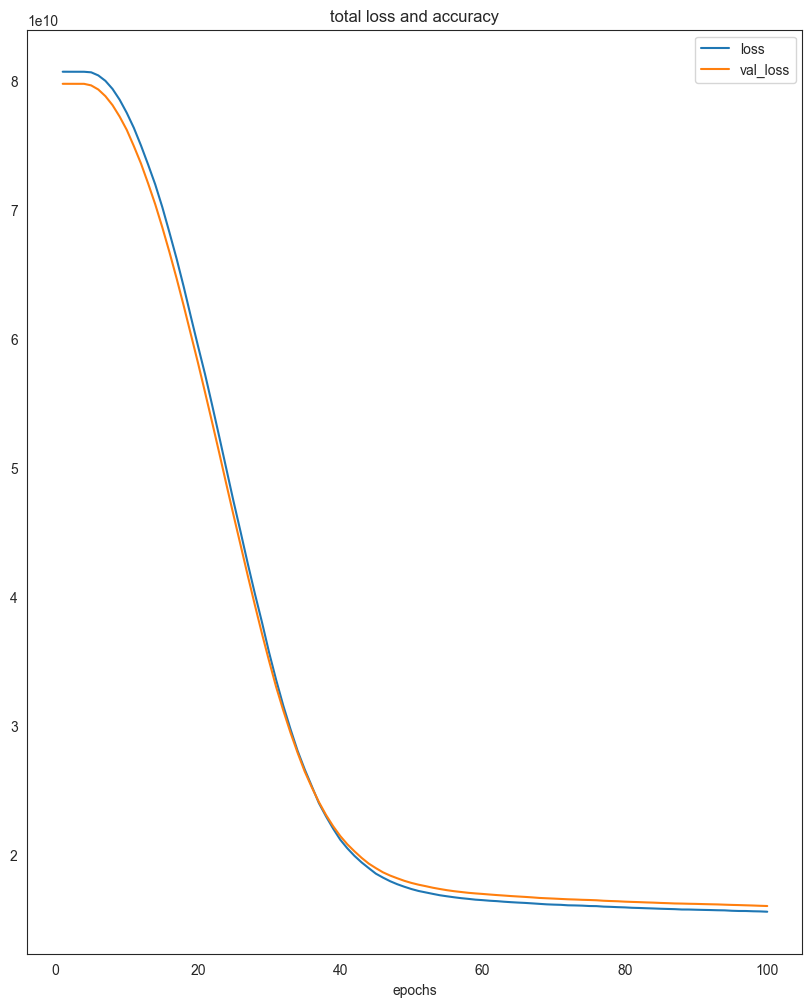

In [134]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label='val_loss')
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

123/123 [==============================] - 0s 791us/step
TRAIN Root Mean Squared Error(RMSE): 80699.29423032906
TEST Root Mean Squared Error(RMSE): 90883.79918263108
ALL RMSE: 78989.00851104624


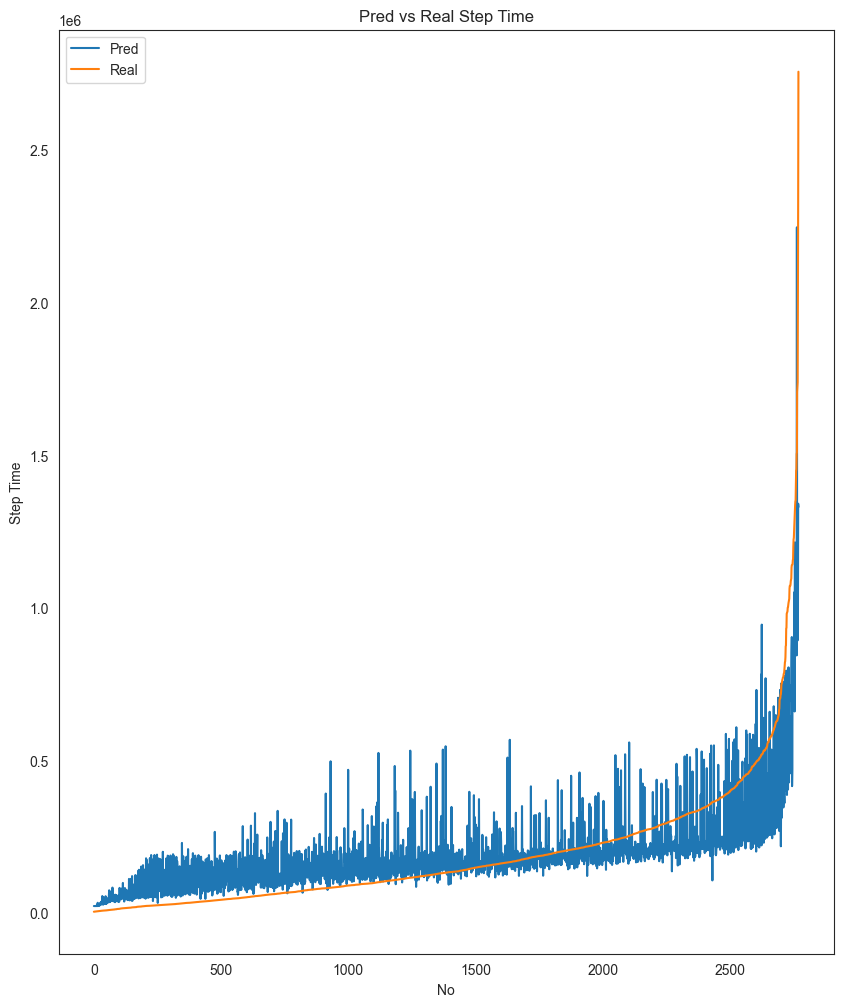

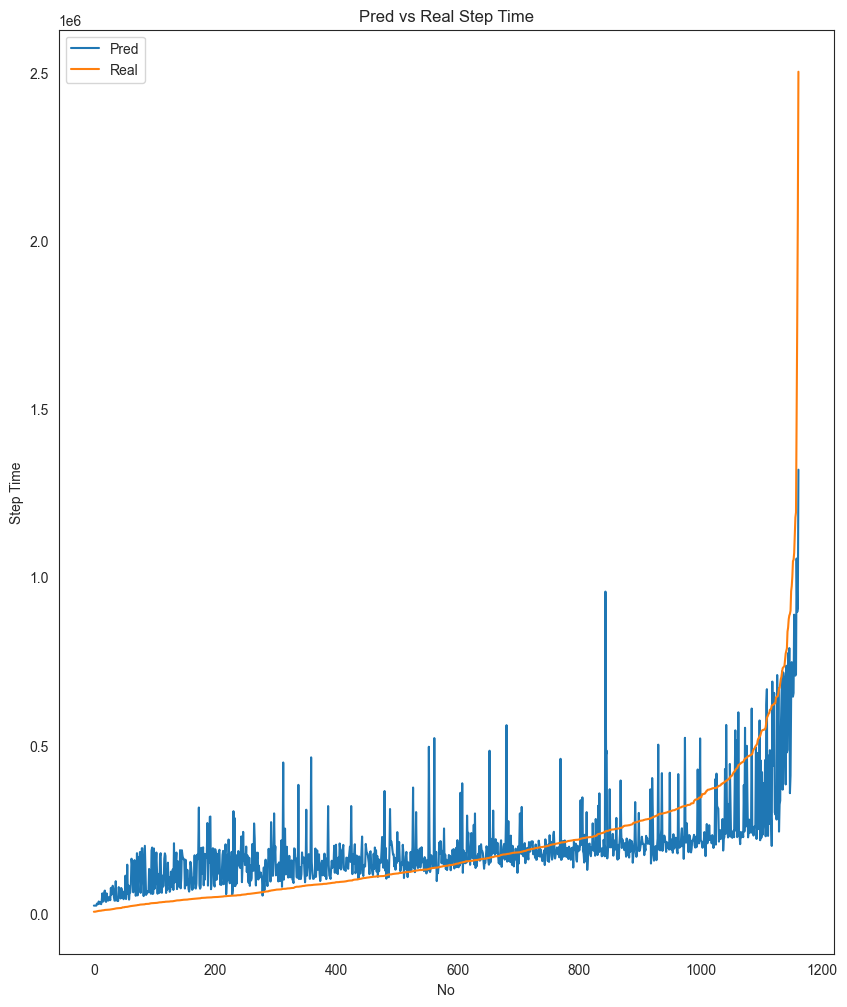

In [135]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [136]:
model = Sequential()
model.add(Dense(units=20, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=1)

Epoch 1/100
2769/2769 [==============================] - 3s 1ms/step - loss: 80347963392.0000 - val_loss: 78794694656.0000
Epoch 2/100
2769/2769 [==============================] - 3s 1ms/step - loss: 78572838912.0000 - val_loss: 76293447680.0000
Epoch 3/100
2769/2769 [==============================] - 3s 1ms/step - loss: 75165212672.0000 - val_loss: 72171593728.0000
Epoch 4/100
2769/2769 [==============================] - 3s 1ms/step - loss: 69983952896.0000 - val_loss: 66560536576.0000
Epoch 5/100
2769/2769 [==============================] - 3s 1ms/step - loss: 63616020480.0000 - val_loss: 59582504960.0000
Epoch 6/100
2769/2769 [==============================] - 3s 1ms/step - loss: 55816192000.0000 - val_loss: 51973300224.0000
Epoch 7/100
2769/2769 [==============================] - 3s 1ms/step - loss: 48243871744.0000 - val_loss: 44461154304.0000
Epoch 8/100
2769/2769 [==============================] - 3s 1ms/step - loss: 40662020096.0000 - val_loss: 37320708096.0000
Epoch 9/100
2769

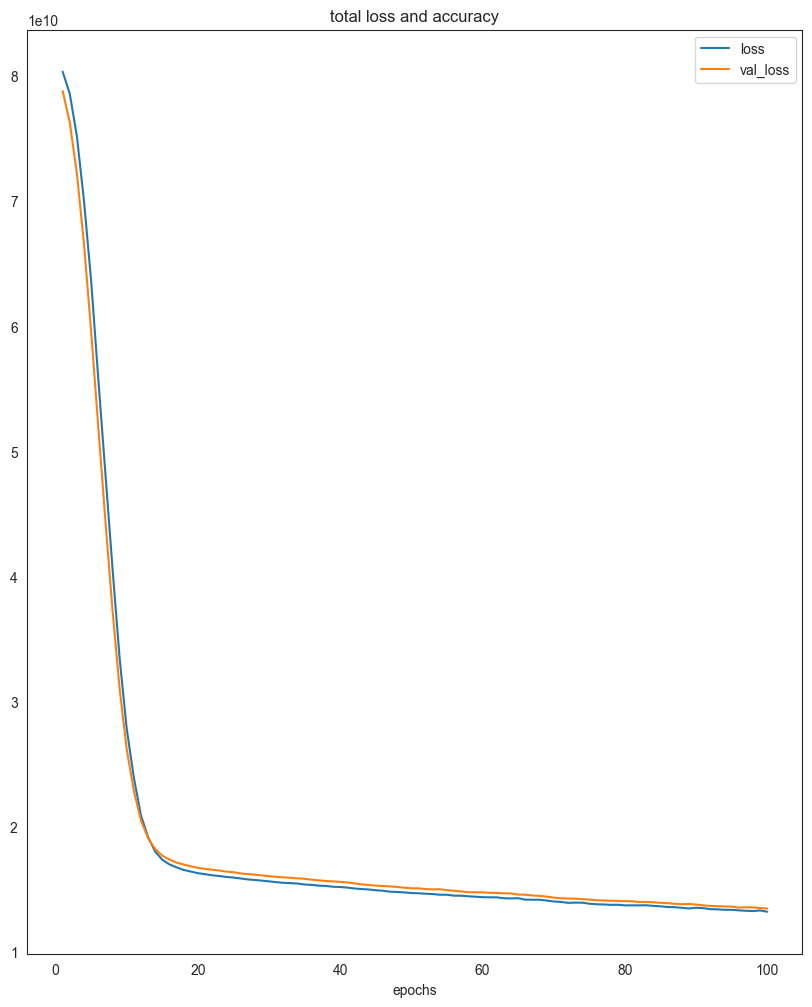

In [137]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label='val_loss')
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

123/123 [==============================] - 0s 895us/step
TRAIN Root Mean Squared Error(RMSE): 80699.29423032906
TEST Root Mean Squared Error(RMSE): 90883.79918263108
ALL RMSE: 78989.00851104624


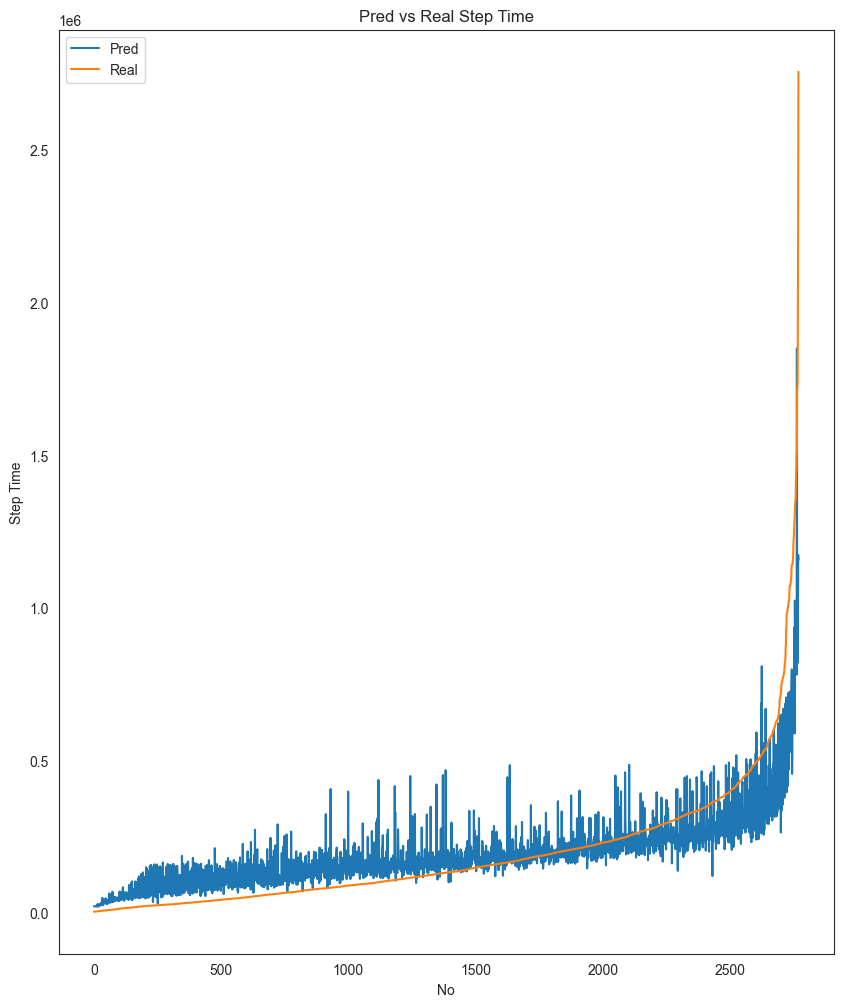

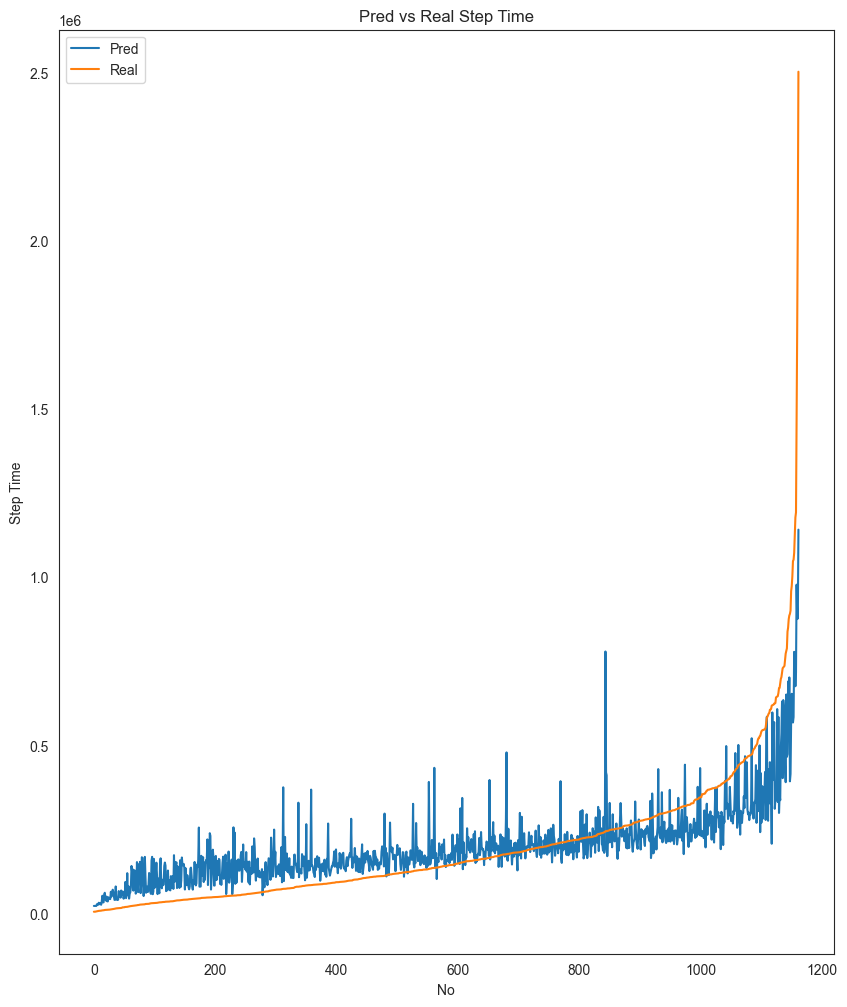

In [138]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [139]:
model = Sequential()
model.add(Dense(units=20, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=1)

Epoch 1/100
2769/2769 [==============================] - 4s 1ms/step - loss: 80167903232.0000 - val_loss: 78446313472.0000
Epoch 2/100
2769/2769 [==============================] - 3s 1ms/step - loss: 77792378880.0000 - val_loss: 75240857600.0000
Epoch 3/100
2769/2769 [==============================] - 3s 1ms/step - loss: 73710485504.0000 - val_loss: 70217703424.0000
Epoch 4/100
2769/2769 [==============================] - 3s 1ms/step - loss: 68022837248.0000 - val_loss: 63781806080.0000
Epoch 5/100
2769/2769 [==============================] - 3s 1ms/step - loss: 60397273088.0000 - val_loss: 56308940800.0000
Epoch 6/100
2769/2769 [==============================] - 3s 1ms/step - loss: 52336103424.0000 - val_loss: 48418603008.0000
Epoch 7/100
2769/2769 [==============================] - 3s 1ms/step - loss: 44175302656.0000 - val_loss: 40825606144.0000
Epoch 8/100
2769/2769 [==============================] - 3s 1ms/step - loss: 37074169856.0000 - val_loss: 33892188160.0000
Epoch 9/100
2769

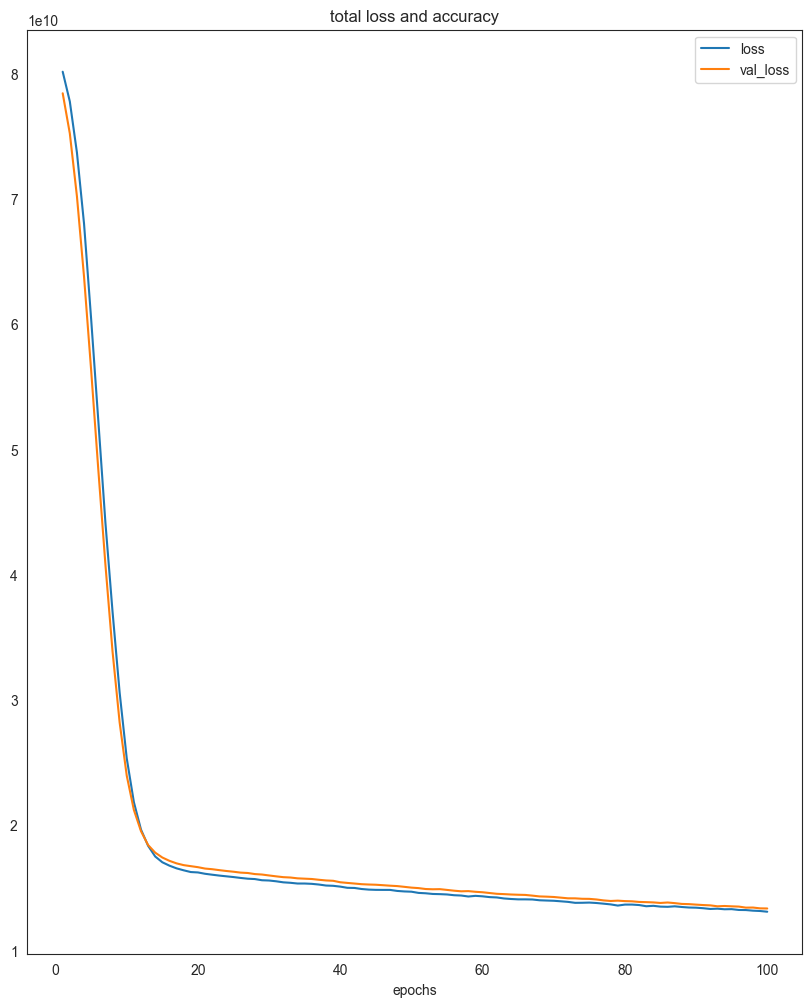

In [140]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label='val_loss')
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

123/123 [==============================] - 0s 761us/step
TRAIN Root Mean Squared Error(RMSE): 80699.29423032906
TEST Root Mean Squared Error(RMSE): 90883.79918263108
ALL RMSE: 78989.00851104624


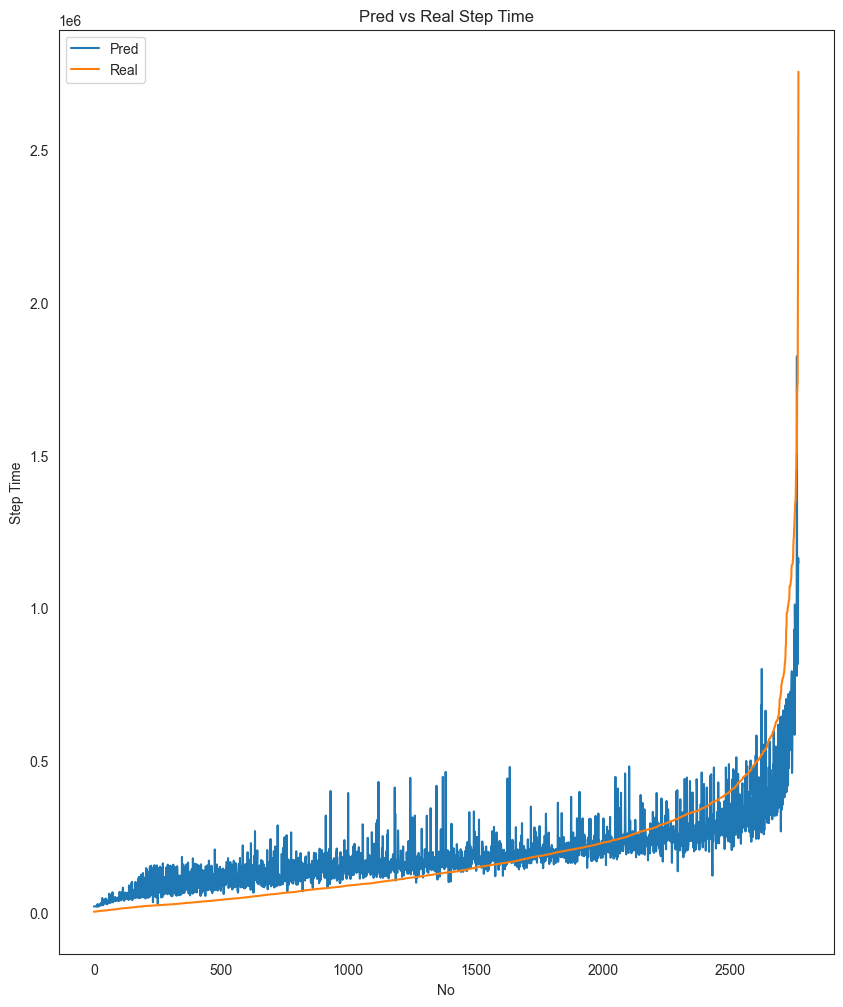

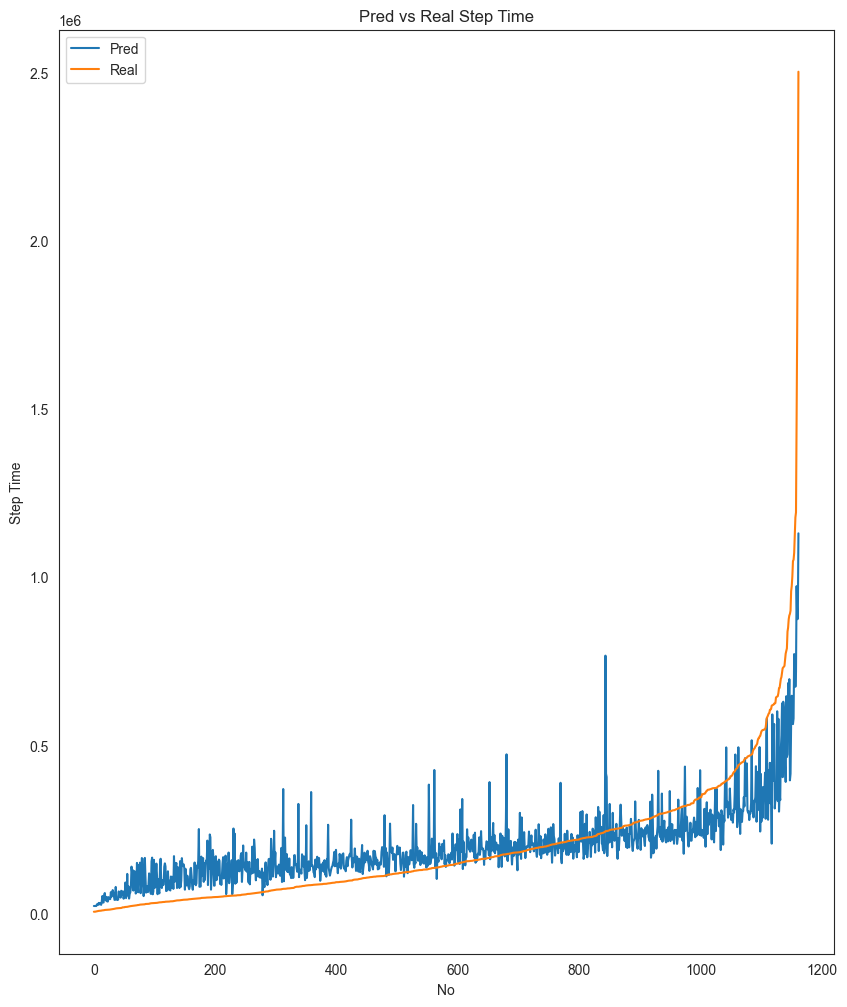

In [141]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [142]:
model = Sequential()
model.add(Dense(units=30, activation='relu', input_dim=5))
model.add(Dense(units=20, activation='relu', input_dim=5))
model.add(Dense(units=10, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=1)

Epoch 1/100
2769/2769 [==============================] - 4s 1ms/step - loss: 55850692608.0000 - val_loss: 17594626048.0000
Epoch 2/100
2769/2769 [==============================] - 3s 1ms/step - loss: 16321879040.0000 - val_loss: 16120121344.0000
Epoch 3/100
2769/2769 [==============================] - 3s 1ms/step - loss: 15489122304.0000 - val_loss: 15471258624.0000
Epoch 4/100
2769/2769 [==============================] - 3s 1ms/step - loss: 14854460416.0000 - val_loss: 15045953536.0000
Epoch 5/100
2769/2769 [==============================] - 3s 1ms/step - loss: 14160887808.0000 - val_loss: 14365104128.0000
Epoch 6/100
2769/2769 [==============================] - 3s 1ms/step - loss: 13601872896.0000 - val_loss: 14117863424.0000
Epoch 7/100
2769/2769 [==============================] - 3s 1ms/step - loss: 13163201536.0000 - val_loss: 13287737344.0000
Epoch 8/100
2769/2769 [==============================] - 3s 1ms/step - loss: 12830548992.0000 - val_loss: 12382475264.0000
Epoch 9/100
2769

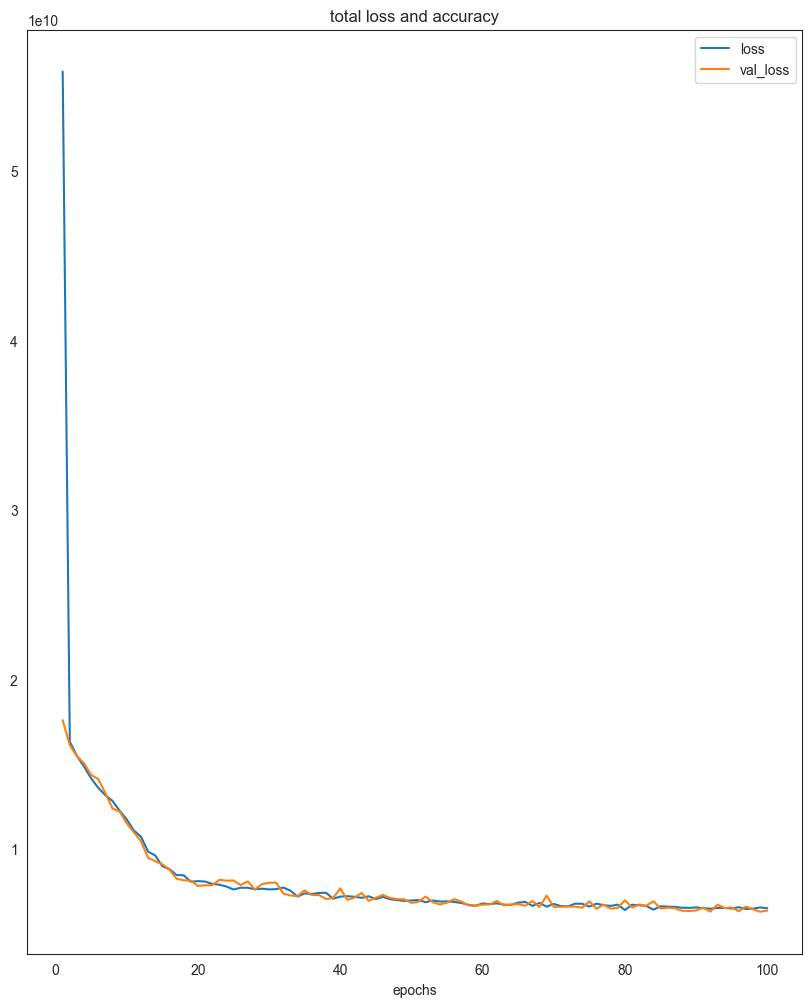

123/123 [==============================] - 0s 781us/step


In [143]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label='val_loss')
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

123/123 [==============================] - 0s 775us/step
TRAIN Root Mean Squared Error(RMSE): 80699.29423032906
TEST Root Mean Squared Error(RMSE): 90883.79918263108
ALL RMSE: 78989.00851104624


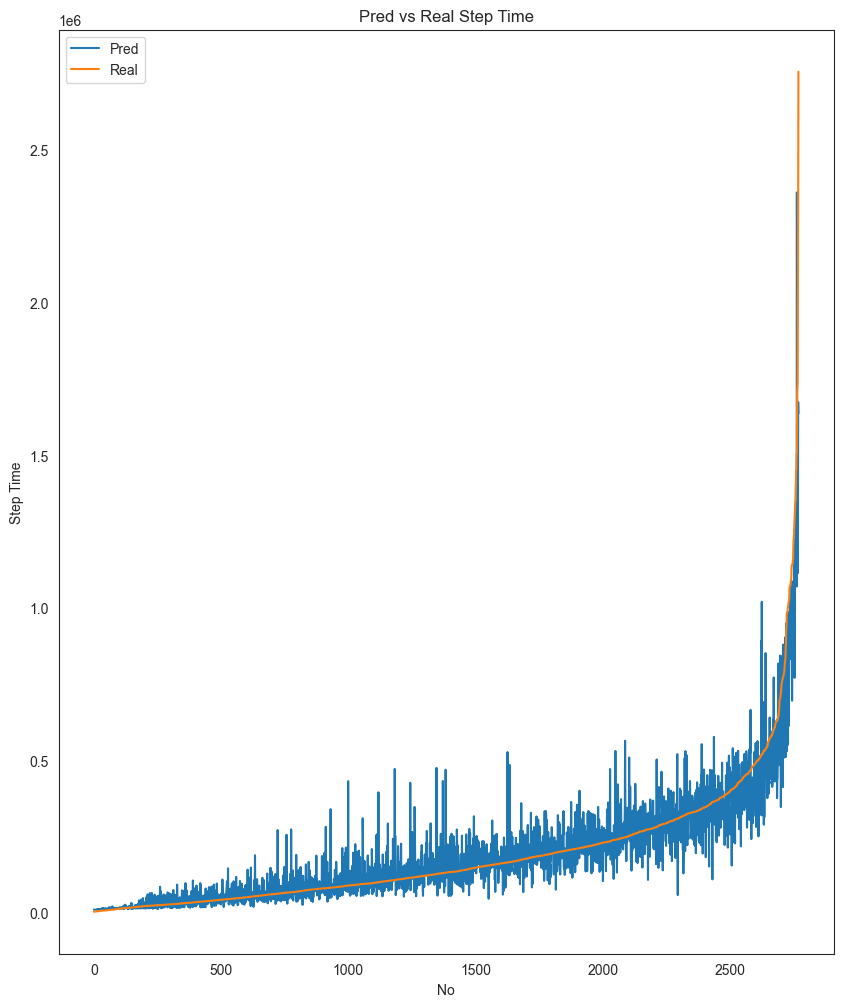

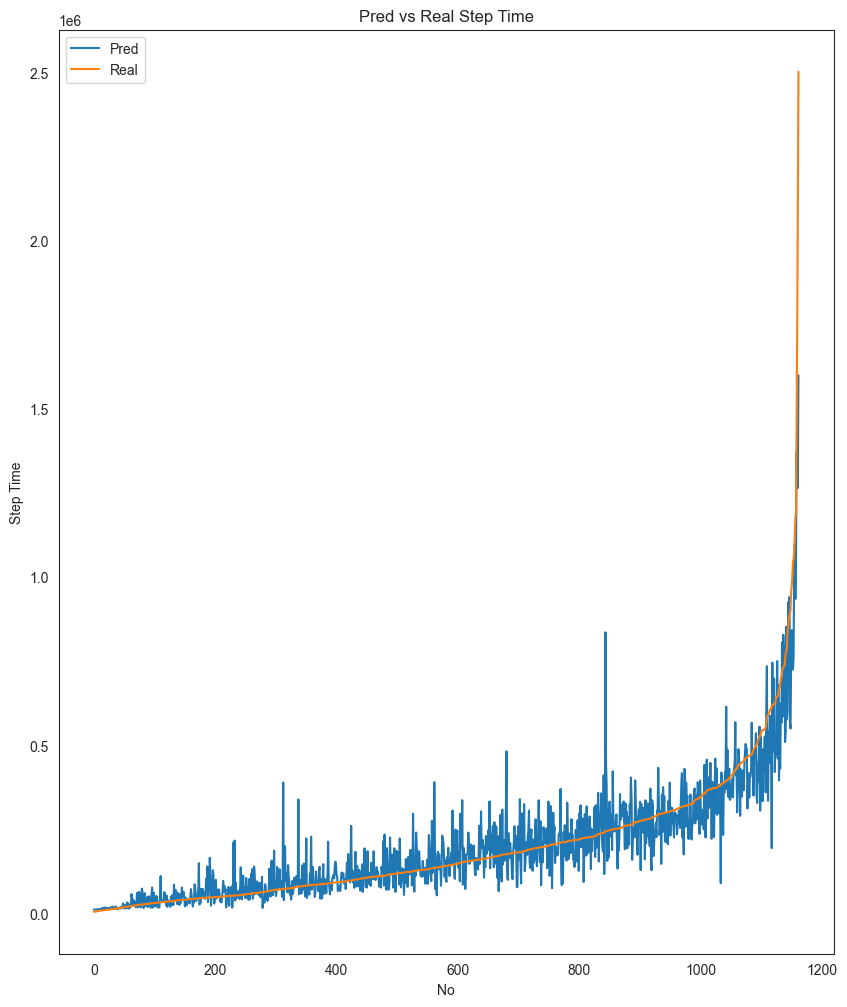

In [144]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())